## Imports

In [1]:
from collections import OrderedDict
import configparser
from functools import partial
import numpy as np
from shapely import Polygon
import math
from typing import Any
from matplotlib.backend_bases import MouseEvent, MouseButton
from matplotlib.gridspec import GridSpec
from matplotlib import pyplot as plt
import logging

import os
import sys
sys.path.insert(1, os.path.realpath(os.path.pardir))

from bbtoolkit.preprocessing.environment.viz import plot_arrow, plot_polygon
from bbtoolkit.data import Cached
from bbtoolkit.data.configparser import EvalConfigParser
from bbtoolkit.preprocessing.environment import Environment
from bbtoolkit.preprocessing.environment.compilers import DynamicEnvironmentCompiler
from bbtoolkit.preprocessing.environment.compilers.callbacks import TransparentObjects
from bbtoolkit.preprocessing.environment.utils import env2builder
from bbtoolkit.preprocessing.environment.visible_planes import LazyVisiblePlaneWithTransparancy
from bbtoolkit.preprocessing.neural_generators import TCGenerator
from bbtoolkit.structures.geometry import Texture, TexturedPolygon
from bbtoolkit.dynamics.callbacks import BaseCallback
from bbtoolkit.preprocessing.environment.fov import FOVManager
from bbtoolkit.preprocessing.environment.fov.ego import EgoManager
from bbtoolkit.math import pol2cart
from bbtoolkit.math.geometry import calculate_polar_distance
from bbtoolkit.dynamics import DynamicsManager
from bbtoolkit.dynamics.callbacks.fov import EgoCallback, EgoSegmentationCallback, FOVCallback, ParietalWindowCallback
from bbtoolkit.dynamics.callbacks.movement import MovementCallback, MovementSchedulerCallback, TrajectoryCallback
from bbtoolkit.movement import MovementManager
from bbtoolkit.dynamics.attention import RhythmicAttention
from bbtoolkit.dynamics.callbacks.attention import AttentionCallback
from bbtoolkit.movement.trajectory import AStarTrajectory


logging.basicConfig(
    level=logging.DEBUG,
    format='%(asctime)s - %(levelname)s - %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S'
)

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def create_circular_layout(N: int, d: float = 5, figsize: tuple[int, int] = (5, 5)) -> tuple[plt.Figure, list[plt.Axes]]:
    """
    Creates a circular layout for a matplotlib figure with N axes.

    Args:
        N (int): The number of axes to create in the circular layout.
        d (int): The radius of the circular layout.
        figsize (tuple[int, int]): The size of the figure.

    Returns:
        tuple[plt.Figure, list[plt.Axes]]: The figure and the axes.
    """
    fig = plt.figure(figsize=figsize)
    axs = []
    gs = GridSpec(int(2*d*1000 + 500), int(2*d*1000 + 500), figure=fig)
    theta = np.linspace(0.0, 2 * np.pi, N, endpoint=False)

    max_a, max_b = 0, 0

    for i in range(N):
        # Calculate the angle for each subplot

        # Set the position of the subplot
        a = int((d*np.cos(theta[i]) + d) * 500)
        b = int((d*np.sin(theta[i]) + d) * 500)

        if a > max_a:
            max_a = a
        if b > max_b:
            max_b = b

        ax = fig.add_subplot(gs[a:a+1000, b:b+1000], projection='3d')

        axs.append(ax)
    axs = [
            fig.add_subplot(gs[
                max_a//2: max_a//2 + 1000,
                max_b//2: max_b//2 + 1000
            ], polar=True)
        ] + axs

    return fig, axs


### Define Transformation Circuit and Environment

In [3]:
from dataclasses import dataclass
import numpy as np
import os
import configparser
from abc import ABC, abstractmethod
from numba import jit
from bbtoolkit.data import WritablePickle
from bbtoolkit.math import triple_gaussian
from bbtoolkit.math.geometry import calculate_polar_distance
from bbtoolkit.preprocessing import triple_arange
from bbtoolkit.preprocessing.environment import Environment
from scipy.sparse import csr_matrix
from bbtoolkit.preprocessing.neural_generators import AbstractGenerator, get_boundary_activations
from bbtoolkit.structures.geometry import Coordinates2D
from bbtoolkit.structures.synapses import DirectedTensorGroup, DirectedTensor
import matplotlib.pyplot as plt

class MTLGenerator(AbstractGenerator):

    def __init__(
        self,
        r_max: int,
        h_sig: float,
        polar_dist_res: int,
        polar_ang_res: int,
        environment: Environment
    ):
        self.r_max = r_max
        self.h_sig = h_sig
        self.polar_dist_res = polar_dist_res
        self.polar_ang_res = polar_ang_res
        self.environment = environment
        self.res = self.environment.params.res

        self.sigma_th = np.sqrt(0.05)
        self.sigma_r0 = 0.08
        self.alpha_small = 1e-6

    def get_coords(self) -> tuple[Coordinates2D, int, Coordinates2D]:
        # coords_x, coords_y = self.environment.visible_area.boundary.coords.xy
        coords_x, coords_y = self.environment.params.coords[:, 0], self.environment.params.coords[:, 1]
        min_train_x, max_train_x, min_train_y, max_train_y = min(coords_x), max(coords_x), min(coords_y), max(coords_y)

        n_neurons = Coordinates2D( #  Total H neurons in each dir
            int((max_train_x - min_train_x)/self.res),
            int((max_train_y - min_train_y)/self.res),
        )
        n_neurons_total = n_neurons.x * n_neurons.y #  Total H neurons
        coords = Coordinates2D(*np.meshgrid( # x,y cords for all H neurons
            np.arange(
                min_train_x + self.res/2,
                min_train_x + (n_neurons.x - 0.5) * self.res + self.res,
                self.res
            ),
            np.arange(
                min_train_y + self.res/2,
                min_train_y + (n_neurons.y - 0.5) * self.res + self.res,
                self.res
            )
        ))
        return coords, n_neurons_total, n_neurons

    def get_bvc_params(self) -> tuple[int, np.ndarray, np.ndarray]:
        n_bvc_r = self.r_max // self.polar_dist_res # Num BVCs along a radius
        n_bvc_theta = int(np.floor( (2*np.pi - 0.01) / self.polar_ang_res ) + 1) # Num BVCs in a ring
        n_bvc = n_bvc_r * n_bvc_theta
        polar_dist = calculate_polar_distance(self.r_max)

        polar_ang = np.arange(0, n_bvc_theta * self.polar_ang_res, self.polar_ang_res)
        p_dist, p_ang = np.meshgrid(polar_dist, polar_ang) #  polar coords of all BVC neurons

        bvc_dist = p_dist.flatten() # Same, but in column vector
        bvc_ang = p_ang.flatten()

        bvc_ang = bvc_ang - 2 * np.pi * (bvc_ang > np.pi) # Make sure angles in correct range

        return n_bvc, bvc_dist, bvc_ang

    def get_perifirical_cells_params(self) -> tuple[int, np.ndarray]:
        n_pr = len(set(wall.polygon.texture.id_ for wall in self.environment.walls)) # One perirhinal neuron for each wall identity/texture (walls only)
        pr_activations = np.eye(n_pr) # identity matrix
        return n_pr, pr_activations

    @staticmethod
    def get_h_sq_distances(coords: Coordinates2D, n_neurons_total: int) -> np.ndarray:
        h_separations = Coordinates2D(
            (np.outer(coords.x, np.ones(n_neurons_total)) - np.outer(coords.x, np.ones(n_neurons_total)).T).T,
            (np.outer(coords.y, np.ones(n_neurons_total)) - np.outer(coords.y, np.ones(n_neurons_total)).T).T
        )

        # Calculate square distances
        h_sq_distances = h_separations.x**2 + h_separations.y**2

        return h_sq_distances

    @staticmethod
    def initialize_h2h_weights(h_sq_distances: np.ndarray, h_sig: float) -> np.ndarray:
        h2h_weights = np.exp(-h_sq_distances / (h_sig**2))
        return h2h_weights

    @staticmethod
    def initialize_pr2pr_weights(n_pr: int) -> np.ndarray:
        # Initialize pr2pr_weights
        return np.zeros((n_pr, n_pr))

    @staticmethod
    def initialize_bvc2bvc_weights(n_bvc: int) -> np.ndarray:
        # Initialize bvc2bvc_weights
        return np.zeros((n_bvc, n_bvc))

    def initialize_auto_weights(
        self,
        h_sq_distances: np.ndarray,
        h_sig: float,
        n_pr: int,
        n_bvc: int
    ):
        return self.initialize_h2h_weights(h_sq_distances, h_sig), self.initialize_pr2pr_weights(n_pr), self.initialize_bvc2bvc_weights(n_bvc)

    def initialize_cross_weights(
        self,
        n_h_neurons_total: int,
        n_bvc: int,
        n_pr: int,
        coords: Coordinates2D,
        bvc_ang: np.array,
        bvc_dist: np.ndarray,
        pr_activations: np.ndarray
    ) -> tuple[
        np.ndarray,
        np.ndarray,
        np.ndarray,
        np.ndarray,
        np.ndarray,
        np.ndarray,
    ]:
        bvc2h_weights = np.zeros((n_h_neurons_total, n_bvc))
        bvc2pr_weights = np.zeros((n_pr, n_bvc))
        pr2h_weights = np.zeros((n_h_neurons_total, n_pr))
        h2pr_weights = pr2h_weights.T

        for location in range(self.environment.walls[0].visible_parts.shape[0]):
            pos_x = self.environment.params.coords[location, 0]
            pos_y = self.environment.params.coords[location, 1]
            all_visible_parts_x, all_visible_parts_y, all_non_nan_indices, all_boundary_point_texture = list(), list(), list(), list()
            for wall in self.environment.walls:
                visible_parts_x = wall.visible_parts[location, :, 0]
                visible_parts_y = wall.visible_parts[location, :, 1]
                non_nan_indices = np.where(~np.isnan(visible_parts_x))[0]
                boundary_point_texture = wall.polygon.texture.id_*np.ones_like(non_nan_indices)
                all_visible_parts_x.append(visible_parts_x[non_nan_indices])
                all_visible_parts_y.append(visible_parts_y[non_nan_indices])
                all_non_nan_indices.append(non_nan_indices)
                all_boundary_point_texture.append(boundary_point_texture)

            visible_parts_x = np.concatenate(all_visible_parts_x)
            visible_parts_y = np.concatenate(all_visible_parts_y)
            visible_boundary_points = Coordinates2D(
                visible_parts_x - pos_x,
                visible_parts_y - pos_y
            )
            non_nan_indices = np.concatenate(all_non_nan_indices)
            boundary_point_texture = np.concatenate(all_boundary_point_texture)

            boundary_theta, boundary_r = np.arctan2(visible_boundary_points.y, visible_boundary_points.x), np.sqrt(visible_boundary_points.x**2 + visible_boundary_points.y**2)
            boundary_r[boundary_r < self.polar_dist_res] = self.polar_dist_res

            h_activarions = np.exp(-((coords.x.reshape((-1, 1)) - pos_x)**2 + (coords.y.reshape((-1, 1)) - pos_y)**2) / (self.h_sig**2))
            bvc_activations = np.zeros(n_bvc)
            bvc2pr_weights_contrib = np.zeros(bvc2pr_weights.shape)
            h2pr_weights_contrib = np.zeros(h2pr_weights.shape)

            for boundary_point in range(visible_boundary_points.x.size):
                delayed_bvc_activations = get_boundary_activations(
                    bvc_ang,
                    boundary_theta[boundary_point],
                    bvc_dist,
                    boundary_r[boundary_point],
                    sigma_r0=self.sigma_r0,
                    sigma_th=self.sigma_th,
                    mask=bvc_activations <= 1
                )
                bvc_activations += delayed_bvc_activations
                bvc2pr_weights_contrib += np.outer(pr_activations[:, int(boundary_point_texture[boundary_point]) - 1], delayed_bvc_activations)
                h2pr_weights_contrib += np.outer(pr_activations[:, int(boundary_point_texture[boundary_point]) - 1], h_activarions)

            bvc2h_weights_contrib = np.outer(h_activarions, bvc_activations)
            # if location == 0:
            #     fig, (ax1, ax2) = plt.subplots(1, 2)
            #     ax1.imshow(bvc2h_weights_contrib, aspect='auto', origin='lower')
            #     ax2.imshow(np.reshape((bvc2h_weights_contrib.sum(1)), (58, 58)), aspect='auto', origin='lower')
            #     plt.show()
            #     raise ValueError(
            #         f'{location = }, '
            #         f'{bvc2h_weights_contrib.shape = }, ',
            #         f'coords = {(env.params.coords[location] - env.params.coords.min(0))/env.params.res}, '
            #         f'pos = {pos_x, pos_y}, {env.params.coords[location]}'
            #     )
            bvc2h_weights += bvc2h_weights_contrib
            bvc2pr_weights += bvc2pr_weights_contrib
            h2pr_weights += h2pr_weights_contrib

        h2bvc_weights, pr2bvc_weights, pr2h_weights = self.invert_weights(bvc2h_weights, bvc2pr_weights, h2pr_weights)

        # Post-synaptic normalization
        bvc2h_weights, h2bvc_weights, bvc2pr_weights, pr2bvc_weights, h2pr_weights, pr2h_weights = self.normalize_weights(
            bvc2h_weights,
            h2bvc_weights,
            bvc2pr_weights,
            pr2bvc_weights,
            h2pr_weights,
            pr2h_weights
        )

        return bvc2h_weights, bvc2pr_weights, pr2h_weights, h2pr_weights, h2bvc_weights, pr2bvc_weights

    @staticmethod
    def invert_weights(*weights: np.ndarray) -> tuple[np.ndarray, ...]:
        return tuple([weight.T for weight in weights])

    def normalize_weights(
        self,
        bvc2h_weights: np.ndarray,
        h2bvc_weights: np.ndarray,
        bvc2pr_weights: np.ndarray,
        pr2bvc_weights: np.ndarray,
        h2pr_weights: np.ndarray,
        pr2h_weights: np.ndarray
    ) -> tuple[
        np.ndarray,
        np.ndarray,
        np.ndarray,
        np.ndarray,
        np.ndarray,
        np.ndarray
    ]:
        # FIXME: In the future can be refactored, now made to be consistent with legacy code
        bvc2h_weights = bvc2h_weights / (np.sum(bvc2h_weights, axis=1, keepdims=True) + self.alpha_small)
        h2bvc_weights = h2bvc_weights / (np.sum(h2bvc_weights, axis=1, keepdims=True) + self.alpha_small)

        bvc2pr_weights = bvc2pr_weights / (np.sum(bvc2pr_weights, axis=1, keepdims=True) + self.alpha_small)
        pr2bvc_weights = pr2bvc_weights / (np.sum(pr2bvc_weights, axis=1, keepdims=True)  + self.alpha_small)
        h2pr_weights = h2pr_weights / (np.sum(h2pr_weights, axis=1, keepdims=True) + self.alpha_small)
        pr2h_weights = pr2h_weights / (np.sum(pr2h_weights, axis=1, keepdims=True)  + self.alpha_small)

        return bvc2h_weights, h2bvc_weights, bvc2pr_weights, pr2bvc_weights, h2pr_weights, pr2h_weights

    def generate(self):
        coords, n_neurons_total, n_neurons = self.get_coords()
        n_bvc, bvc_dist, bvc_ang = self.get_bvc_params()
        n_pr, pr_activations = self.get_perifirical_cells_params()
        h_sq_distances = self.get_h_sq_distances(coords, n_neurons_total)
        h2h_weights, pr2pr_weights, bvc2bvc_weights = self.initialize_auto_weights(h_sq_distances, self.h_sig, n_pr, n_bvc)
        bvc2h_weights, bvc2pr_weights, pr2h_weights, h2pr_weights, h2bvc_weights, pr2bvc_weights = self.initialize_cross_weights(
            n_neurons_total,
            n_bvc,
            n_pr,
            coords,
            bvc_ang,
            bvc_dist,
            pr_activations
        )
        weights = DirectedTensorGroup(
            DirectedTensor(
                from_ = 'h',
                to = 'h',
                weights = h2h_weights
            ),
            DirectedTensor(
                from_ = 'h',
                to = 'pr',
                weights = h2pr_weights
            ),
            DirectedTensor(
                from_ = 'h',
                to = 'bvc',
                weights = h2bvc_weights
            ),
            DirectedTensor(
                from_ = 'pr',
                to = 'h',
                weights = pr2h_weights
            ),
            DirectedTensor(
                from_ = 'pr',
                to = 'pr',
                weights = pr2pr_weights
            ),
            DirectedTensor(
                from_ = 'pr',
                to = 'bvc',
                weights = pr2bvc_weights
            ),
            DirectedTensor(
                from_ = 'bvc',
                to = 'h',
                weights = bvc2h_weights
            ),
            DirectedTensor(
                from_ = 'bvc',
                to = 'pr',
                weights = bvc2pr_weights
            ),
            DirectedTensor(
                from_ = 'bvc',
                to = 'bvc',
                weights = bvc2bvc_weights
            ),
        )

        return weights

In [4]:
# from bbtoolkit.preprocessing.neural_generators import MTLGenerator


hd_config_path = '../cfg/cells/hd_cells.ini'
hd_config = EvalConfigParser(interpolation=configparser.ExtendedInterpolation(), allow_no_value=True)
hd_config.read(hd_config_path)

mtl_config_path = '../cfg/cells/mtl_cells.ini'
mtl_config = EvalConfigParser(interpolation=configparser.ExtendedInterpolation(), allow_no_value=True)
mtl_config.read(mtl_config_path)

tr_config_path = '../cfg/cells/transformation_circuit.ini'
tr_config = EvalConfigParser(interpolation=configparser.ExtendedInterpolation(), allow_no_value=True)
tr_config.read(tr_config_path)

env_cfg = EvalConfigParser(interpolation=configparser.ExtendedInterpolation(), allow_no_value=True)
env_cfg.read('../cfg/envs/squared_room.ini')

space_cfg = mtl_config['Space']
h_res = space_cfg.eval('res')
r_max = space_cfg.eval('r_max')

mtl_grid_cfg = mtl_config['PolarGrid']
n_radial_points = mtl_grid_cfg.eval('n_radial_points')
polar_dist_res = mtl_grid_cfg.eval('polar_dist_res')
polar_ang_res = mtl_grid_cfg.eval('polar_ang_res', locals={'pi': np.pi})
h_sig = mtl_grid_cfg.eval('sigma_hill')

tr_space_cfg = tr_config['Space']
tr_res = tr_space_cfg.eval('tr_res', locals={'pi': np.pi})
res = tr_space_cfg.eval('res')

n_steps = tr_config['Training'].eval('n_steps')

hd_neurons_cfg = hd_config['Neurons']
sigma_angular = hd_neurons_cfg.eval('sigma', locals={'pi': np.pi})
n_hd = hd_neurons_cfg.eval('n_neurons')


training_rect_cfg = env_cfg['TrainingRectangle']
max_train_x = training_rect_cfg.eval('max_train_x')
min_train_x = training_rect_cfg.eval('min_train_x')
max_train_y = training_rect_cfg.eval('max_train_y')
min_train_y = training_rect_cfg.eval('min_train_y')

# env = Environment.load('../data/envs/main_environment.pkl')
env = Environment.load('../data/envs/square_environment.pkl')

tc_gen = TCGenerator(
    n_hd,
    tr_res,
    res,
    r_max,
    polar_dist_res,
    n_radial_points,
    polar_ang_res,
    sigma_angular,
    n_steps=n_steps
)

mtl_gen = MTLGenerator(
    r_max, h_sig, polar_dist_res, polar_ang_res, env
)

builder = env2builder(env)
cache_manager = Cached(cache_storage=OrderedDict(), max_size=10000)
compiler = DynamicEnvironmentCompiler(
    builder,
    partial(
        LazyVisiblePlaneWithTransparancy,
        cache_manager=cache_manager,
    ),
    callbacks=TransparentObjects()
)

compiler.add_object(
    TexturedPolygon(
        Polygon([
            (-5, -5),
            (-6, -5),
            (-6, -6),
            (-5, -6)
        ]),
        texture=Texture(
            id_=31,
            color='#ffd200',
            name='main_object'
        )
    ),
    TexturedPolygon(
        Polygon([
            (-7, -7),
            (-8, -7),
            (-8, -8),
            (-7, -8)
        ]),
        texture=Texture(
            id_=32,
            color='#ffd200',
            name='main_object'
        )
    ),
    TexturedPolygon(
        Polygon([
            (2, 2),
            (1, 2),
            (1, 1),
            (2, 1)
        ]),
        texture=Texture(
            id_=33,
            color='#ffd200',
            name='main_object'
        )
    ),
    TexturedPolygon(
        Polygon([
            (-2, 2),
            (-1, 2),
            (-1, 1),
            (-2, 1)
        ]),
        texture=Texture(
            id_=34,
            color='#ffd200',
            name='main_object'
        )
    ),
    TexturedPolygon(
        Polygon([
            (7, 7),
            (6, 7),
            (6, 6),
            (7, 6)
        ]),
        texture=Texture(
            id_=35,
            color='#ffd200',
            name='main_object'
        )
    )
)

In [5]:
from bbtoolkit.structures.synapses import DirectedTensorGroup, dict2directed_tensor

def connectivity_config2dict(
    config: EvalConfigParser,
    populations: tuple[str, ...] = None,
    ignore: tuple[str, ...] = None
) -> dict[str, dict[str, Any]]:
    """
    Converts EvalConfigParser object into a nested dictionary with specified sections and populations.

    Args:
        config (EvalConfigParser): An instance of EvalConfigParser containing configuration data.
        populations (tuple[str, ..], optional): A tuple of sections to include.
            If None, read all sections except of 'ExternalSources' and 'Hyperparameters'. Defaults to None.
        ignore (tuple[str, ..], optional): A tuple of sections to ignore. 'ExternalSources' and 'Hyperparameters' sections are always ignored. Defaults to None.

    Returns:
        dict[str, dict[str, Any]]: A nested dictionary containing configuration data organized by sections and populations.
    """
    if populations is None:
        populations = tuple(config.sections())

    if ignore is None:
        ignore = {'ExternalSources', 'Hyperparameters'}
    else:
        ignore = set(list(ignore) + ['ExternalSources', 'Hyperparameters'])

    out = {
        config.optionxform(section): {
            population: config.eval(section, population)
            for population in config[section]
        }
        for section in config.sections() if section in populations and section not in ignore
    }
    return out


config = EvalConfigParser(interpolation=configparser.ExtendedInterpolation(), allow_no_value=True)
config.read('../cfg/connectivity/main.ini')

configdict = connectivity_config2dict(config)
connections = dict2directed_tensor(configdict)
connectivity = DirectedTensorGroup(*connections)

position = 1, -5
# direction = -np.pi/2
direction = 0
fov_angle = np.pi*.9
fov_manager = FOVManager(compiler.environment, fov_angle)
ego_manager = EgoManager(fov_manager)

cache = {'env': compiler.environment, 'tc_gen': tc_gen}
dt = 0.01
n_objects = 5

polar_distance = calculate_polar_distance(tc_gen.r_max)
polar_angle = np.linspace(0, (tc_gen.n_bvc_theta + 1) * tc_gen.polar_ang_res, tc_gen.n_bvc_theta)
polar_distance, polar_angle = np.meshgrid(polar_distance, polar_angle)
pdist, pang = polar_distance, polar_angle
x_bvc, y_bvc = pol2cart(pdist, pang)
hd_polar_res = 2 * np.pi / n_hd
hd_angles = np.arange(0, 2 * np.pi+ hd_polar_res, hd_polar_res) + np.pi/2
hd_dist, hd_ang = np.meshgrid(np.array([1, 1.5]), hd_angles)
hd_x, hd_y = pol2cart(hd_dist, hd_ang)

In [6]:
from bbtoolkit.preprocessing.neural_generators import GCMap

# mtl_weights = DirectedTensorGroup.load('../data/weights/mtl_weights.pkl')
# mtl_weights = DirectedTensorGroup.load('../data/weights/mtl_weights_trunc.pkl')
mtl_weights = DirectedTensorGroup.load('../data/weights/mtl_weights_trunc_square.pkl')
tc_weights = DirectedTensorGroup.load('../data/weights/tc_weights.pkl')
# tc_weights = DirectedTensorGroup.load('../data/weights/tc_weights_90_deg.pkl')
hd_weights = DirectedTensorGroup.load('../data/weights/hd_weights.pkl')
pc_weights = DirectedTensorGroup.load('../data/weights/pc_weights_trunc.pkl')
# pc_weights = DirectedTensorGroup.load('../data/weights/pc_weights.pkl')
gc_map = GCMap.load('../data/weights/gc_map.pkl')

weights = mtl_weights + tc_weights + hd_weights + pc_weights

n_h_neurons = len(weights.h.to.h)
n_bvc_neurons = n_opw_neurons = n_ovc_neurons = len(weights.bvc.to.bvc)
n_pr_neurons = len(weights.pr.to.pr)
n_hd_neurons = len(weights.hd.to.hd)
n_pc_neurons = len(weights.gc.to.h)
n_gc_neurons = len(weights.gc.to.h.T)
n_tc_layers = len(weights.tr.to.pw.T)

In [7]:
a = DirectedTensorGroup(
        DirectedTensor(
            from_ = 'h',
            to = 'h',
            weights = np.zeros((12, 2))
        ),
)
a._data

{'h': {'h': array([[0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.]])}}

In [8]:
from bbtoolkit.structures.synapses import DirectedTensor


tr_projection = DirectedTensorGroup(
    DirectedTensor(
        from_='bvc',
        to='tr',
        weights=np.eye(n_bvc_neurons)
    ),
    DirectedTensor(
        from_='tr',
        to='bvc',
        weights=np.eye(n_bvc_neurons)
    )
)

new_pathways = DirectedTensorGroup(
    DirectedTensor(
        from_='h',
        to='opr',
        weights=np.zeros((n_objects, n_h_neurons))
    ),
    DirectedTensor(
        from_='opr',
        to='h',
        weights=np.zeros((n_h_neurons, n_objects))
    ),
    DirectedTensor(
        from_='h',
        to='ovc',
        weights=np.zeros((n_ovc_neurons, n_h_neurons))
    ),
    DirectedTensor(
        from_='ovc',
        to='h',
        weights=np.zeros((n_h_neurons, n_ovc_neurons))
    ),
    DirectedTensor(
        from_='ovc',
        to='ovc',
        weights=np.zeros((n_ovc_neurons, n_ovc_neurons))
    ),
    DirectedTensor(
        from_='bvc',
        to='ovc',
        weights=np.zeros((n_ovc_neurons, n_bvc_neurons))
    ),
    DirectedTensor(
        from_='ovc',
        to='bvc',
        weights=np.zeros((n_bvc_neurons, n_ovc_neurons))
    ),
    DirectedTensor(
        from_='opw',
        to='opw',
        weights=np.zeros((n_opw_neurons, n_opw_neurons))
    ),
    DirectedTensor(
        from_='ovc',
        to='opr',
        weights=np.zeros((n_objects, n_ovc_neurons))
    ),
    DirectedTensor(
        from_='opr',
        to='ovc',
        weights=np.zeros((n_ovc_neurons, n_objects))
    ),
    DirectedTensor(
        from_='opr',
        to='pw',
        weights=np.zeros((n_opw_neurons, n_objects))
    ),
    DirectedTensor(
        from_='opr',
        to='hd',
        weights=np.zeros((n_hd_neurons, n_objects))
    ),
    DirectedTensor(
        from_='bvc',
        to='opr',
        weights=np.zeros((n_objects, n_bvc_neurons))
    ),
    DirectedTensor(
        from_='opr',
        to='bvc',
        weights=np.zeros((n_bvc_neurons, n_objects))
    ),
    DirectedTensor(
        from_='opr',
        to='opr',
        weights=np.zeros((n_objects, n_objects))
    ),
)

In [9]:
weights += tr_projection
weights += new_pathways

weights = weights.operation_with(connectivity, lambda a, b: a - b.get('inhibitory_phi', 0), on_missing_weights='ignore', on_missing_sources='ignore')

In [10]:
from bbtoolkit.math.geometry import points2segments
from bbtoolkit.structures.synapses import NamedTensor, TensorGroup


activity = TensorGroup(
    NamedTensor('h', np.zeros((n_h_neurons, 1))),
    NamedTensor('bvc', np.zeros((n_bvc_neurons, 1))),
    NamedTensor('pr', np.zeros((n_pr_neurons, 1))),
    NamedTensor('pw', np.zeros((n_bvc_neurons, 1))),
    NamedTensor('hd', np.zeros((n_hd_neurons, 1))),
    NamedTensor('ovc', np.zeros((n_ovc_neurons, 1))),
    NamedTensor('opw', np.zeros((n_opw_neurons, 1))),
    NamedTensor('opr', np.zeros((n_objects, 1))),
    NamedTensor('tr', np.zeros((n_tc_layers, n_bvc_neurons, 1))),
    NamedTensor('otr', np.zeros((n_tc_layers, n_bvc_neurons, 1)))
)

walls_ego, objects_ego = ego_manager(position, direction)
wall_segments = np.concatenate([points2segments(wall) for wall in walls_ego if wall.size])
ego_input_walls = tc_gen.get_grid_activity(wall_segments)
hd_cue_init = 40*tc_gen.get_hd_activity(np.array([direction]))
hd_cue = np.zeros_like(hd_cue_init)
ohd_cue = hd_cue.copy()
pr_cue = np.zeros((n_pr_neurons, 1))

k_ratio = TensorGroup(
    NamedTensor('h', np.zeros((n_h_neurons, 1))),
    NamedTensor('bvc', np.zeros((n_bvc_neurons, 1))),
    NamedTensor('pr', np.zeros((n_pr_neurons, 1))),
    NamedTensor('opr', np.zeros((n_objects, 1))),
    NamedTensor('hd', np.zeros((n_hd_neurons, 1))),
    NamedTensor('pw', np.expand_dims(40*ego_input_walls, 1)), # FIXME: why 40?
    NamedTensor('ovc', np.zeros((n_ovc_neurons, 1))),
    NamedTensor('opw', np.zeros((n_opw_neurons, 1))),
    NamedTensor('tr', np.zeros((n_tc_layers, n_bvc_neurons, 1))),
    NamedTensor('otr', np.zeros((n_tc_layers, n_bvc_neurons, 1))),
)

activity.pw += dt/connectivity.pw.to.pw['tau']*k_ratio.pw

In [11]:
def activity2rate(activity: TensorGroup, connectivity: DirectedTensorGroup) -> TensorGroup:
    """
    Converts the activity of a TensorGroup to firing rates using a sigmoid projection.

    Args:
        activity (TensorGroup): The activity of the neurons.
        connectivity (DirectedTensorGroup): The synaptic connectivity between the neurons.

    Returns:
        TensorGroup: The firing rates of the neurons.
    """
    rates = TensorGroup()
    for key, tensor in activity.data.items():
        key_ = 'pr' if 'pr' in key else key # object identity cells, use same beta and alpha as other PR neurons by definition
        rates.add_tensor(
            NamedTensor(
                key,
                1/(
                    1 + np.exp(-2*connectivity[key_, key_]['beta']*(tensor - connectivity[key_, key_]['alpha']))
                )
            )
        )
    return rates

In [12]:
rates = activity2rate(activity, connectivity)
rates.add_tensor(NamedTensor('gc', np.array([])))
rates.add_tensor(NamedTensor('ip', np.array([])))

### Define callback for plotting

In [13]:
from typing import Mapping


class PlottingCallback(BaseCallback):
    """
    A callback class designed for plotting and visualizing various aspects of a simulation environment and agent behavior.

    This callback integrates with matplotlib to create a multi-panel figure that visualizes the environment, the agent's
    field of view (FOV), ego-centric representation, parietal window (PW) representation, and the agent's trajectory. It
    allows for interactive target setting through mouse clicks on the plot.

    Attributes:
        x_bvc (np.ndarray): The x-coordinates for plotting the BVC (Boundary Vector Cell) activity in the PW representation.
        y_bvc (np.ndarray): The y-coordinates for plotting the BVC activity in the PW representation.
        update_rate (int): The rate at which the plots are updated (every `update_rate` simulation steps).

    Args:
        x_bvc (np.ndarray): The x-coordinates for the BVC activity plot.
        y_bvc (np.ndarray): The y-coordinates for the BVC activity plot.
        update_rate (int, optional): The update rate for the plots. Defaults to 100.

    Methods:
        set_cache(cache: Any):
            Sets the cache for the callback and initializes required keys for plotting.

        on_click(event: KeyEvent):
            Handles mouse click events on the plot for setting movement and rotation targets.

        on_step_end(step: int):
            Updates the plots at the end of each simulation step, based on the specified update rate.

        on_simulation_end(n_cycles_passed: int):
            Closes the plot window at the end of the simulation.

        plot():
            Generates and updates all subplots within the figure.

        clean_axes():
            Clears and resets the axes for the next plot update.

        plot_environment():
            Plots the environment, including walls and objects.

        plot_fov():
            Plots the agent's field of view, showing visible walls and objects.

        plot_ego():
            Plots the ego-centric representation of walls and objects.

        plot_agent():
            Plots the agent's current position and direction.

        plot_pw():
            Plots the parietal window representation of walls and objects.

        plot_trajectory():
            Plots the agent's current trajectory towards a target.
    """
    def __init__(
        self,
        x_bvc: np.ndarray,
        y_bvc: np.ndarray,
        update_rate: int = 10
    ):
        """
        Initializes the PlottingCallback object.

        Args:
            x_bvc (np.ndarray): The x-coordinates for the BVC activity plot.
            y_bvc (np.ndarray): The y-coordinates for the BVC activity plot.
            update_rate (int, optional): The update rate for the plots. Defaults to 100.
        """
        super().__init__()
        self.x_bvc = x_bvc
        self.y_bvc = y_bvc
        self.update_rate = update_rate
        self.step = 0
        # Create a figure and a plot
        self.fig = plt.figure(figsize=(10, 5))
        # Create a GridSpec layout
        self.gs = GridSpec(12, 12, figure=self.fig)

        # Add the first subplot on the left side (spanning two rows)
        self.ax1 = self.fig.add_subplot(self.gs[:6, :5])

        # Add the second subplot on the top right
        self.ax2 = self.fig.add_subplot(self.gs[:3, 6:9])

        # Add the third subplot on the bottom right with 3D projection
        self.ax3 = self.fig.add_subplot(self.gs[6:, 6:9], projection='3d')

        # self.ax4 = self.fig.add_subplot(self.gs[7:10, 8:10])
        self.ax4 = self.fig.add_subplot(self.gs[6:, 9:12], projection='3d')

        # self.ax5 = self.fig.add_subplot(self.gs[10:, 6:12], projection='polar')
        self.ax5 = self.fig.add_subplot(self.gs[10:, 6:9])

        self.ax6 = self.fig.add_subplot(self.gs[4:7, 6:9], projection='polar')

        # self.ax7 = self.fig.add_subplot(self.gs[3:6, 9:12], projection='3d')
        self.ax7 = self.fig.add_subplot(self.gs[:5, 8:12], projection='3d')

        self.ax8 = self.fig.add_subplot(self.gs[10:, 9:12])

        self.ax9 = self.fig.add_subplot(self.gs[5:8, 9:12], projection='3d')

        # self.ax10 = self.fig.add_subplot(self.gs[7:10, :3])
        # self.ax10 = self.fig.add_subplot(self.gs[7:10, :3], projection='3d')
        # self.ax10 = self.fig.add_subplot(self.gs[6:, :6], projection='3d')
        self.ax10 = self.fig.add_subplot(self.gs[6:, :6])
        # self.ax11 = self.fig.add_subplot(self.gs[10:, :6])

        # plt.subplots_adjust(bottom=0.2)

        # Set the limits of the plot
        self.clean_axes()

        # # Connect the key press event to the handler
        # self.fig.canvas.mpl_connect('key_press_event', self.on_key)
        self.fig.canvas.mpl_connect('button_press_event', self.on_click)

    def set_cache(self, cache: Mapping):
        """
        Sets the cache for the callback and initializes required keys for plotting.

        Args:
            cache (Any): The cache to be set for the callback.
        """

        self.requires = [
            'env',
            'tc_gen',
            'walls_fov',
            'objects_fov',
            'walls_ego',
            'objects_ego',
            'walls_ego_segments',
            'objects_ego_segments',
            'walls_pw',
            'objects_pw',
            'movement_params',
            'movement_schedule',
            'trajectory',
            'attention_params',
            'hd_cue'
        ]
        super().set_cache(cache)

    def on_click(self, event: MouseEvent):
        """
        Handles mouse click events on the plot for setting movement and rotation targets.

        Args:
            event (MouseEvent): The mouse click event on the plot.
        """
        # self.plot()

        if event.inaxes is self.ax1:

            if event.button is MouseButton.LEFT:
                self.ax1.plot(event.xdata, event.ydata, 'rx')
                self.fig.canvas.draw()
                plt.pause(.00001)
                self.cache['movement_params'].move_target = event.xdata, event.ydata
                self.cache['movement_params'].rotate_target = None
            elif event.button is MouseButton.RIGHT:
                self.ax1.plot(event.xdata, event.ydata, 'co')
                self.fig.canvas.draw()
                plt.pause(.00001)
                self.cache['movement_params'].rotate_target = event.xdata, event.ydata
                self.cache['movement_params'].move_target = None

    def on_step_end(self, step: int):
        """
        Updates the plots at the end of each simulation step, based on the specified update rate.

        Args:
            step (int): The current simulation step.
        """

        if not step % self.update_rate:

            self.plot()

        self.step += 1

    def on_simulation_end(self):
        """
        Closes the plot window at the end of the simulation.

        Args:
            n_cycles_passed (int): The number of simulation cycles that have passed.
        """
        plt.close()

    def plot(self):
        """
        Generates and updates all subplots within the figure.
        """
        self.clean_axes()
        self.plot_environment()
        if self.cache['movement_params'].move_target is not None:
            self.ax1.plot(*self.cache['movement_params'].move_target, 'rx')
        if self.cache['movement_params'].rotate_target is not None:
            self.ax1.plot(*self.cache['movement_params'].rotate_target, 'co')
        self.plot_trajectory()
        self.plot_fov()
        self.plot_ego()
        self.plot_agent()
        self.plot_pw()
        self.plot_hd_ring()
        self.fig.canvas.draw()
        plt.pause(.00001)

    def clean_axes(self):
        """
        Clears and resets the axes for the next plot update.
        """
        self.ax1.clear()
        self.ax2.clear()
        self.ax3.clear()
        self.ax4.clear()
        self.ax5.clear()
        self.ax6.clear()
        self.ax7.clear()
        self.ax8.clear()
        self.ax9.clear()
        self.ax10.clear()
        # self.ax11.clear()

        self.ax1.set_xlim(-10, 10)
        self.ax1.set_ylim(-10, 10)
        self.ax2.set_xlim(-15, 15)
        self.ax2.set_ylim(-1, 15)

        self.ax3.view_init(azim=-90, elev=90)
        self.ax3.margins(x=0)
        self.ax3.set_axis_off()
        self.ax3.set_zlim(0, 1)
        self.ax4.view_init(azim=-90, elev=90)
        self.ax4.margins(x=0)
        self.ax4.set_axis_off()
        self.ax4.set_zlim(0, 1)

        # self.ax5.set_theta_zero_location('E')
        # self.ax5.set_theta_direction(-1)
        # self.ax5.set_xticks(np.linspace(0, 2*np.pi, 4, endpoint=False))
        # self.ax5.set_xticklabels(['0°', '270°', '180°', '90°'])

        self.ax6.set_theta_zero_location('E')
        self.ax6.set_theta_direction(-1)
        self.ax6.set_xticks(np.linspace(0, 2*np.pi, 4, endpoint=False))
        self.ax6.set_xticklabels(['0°', '270°', '180°', '90°'])
        self.ax6.axes.get_yaxis().set_visible(False)

        # self.ax7.view_init(azim=-90, elev=90)
        self.ax7.view_init(azim=0, elev=90)
        self.ax7.margins(x=0)
        self.ax7.set_zlim(0, 1)
        self.ax7.set_axis_off()
        self.ax7.set_facecolor((0.0, 0.0, 0.0, 0))
        self.ax9.view_init(azim=0, elev=90)
        self.ax9.margins(x=0)
        self.ax9.set_zlim(0, 1)
        self.ax9.set_axis_off()
        self.ax9.set_facecolor((0.0, 0.0, 0.0, 0))

        # self.ax10.view_init(azim=180, elev=90)
        # self.ax10.view_init(azim=0, elev=90)
        # self.ax10.set_axis_off()

    def plot_hd_ring(self):
        """
        Plots the HD ring activity.
        """
        if self.cache['hd_cue'] is not None:
            theta = np.linspace(0, 2*np.pi, len(self.cache['hd_cue']))
            # self.ax5.plot(theta, self.cache['hd_cue'][::-1], 'b-')
            # self.ax10.plot(self.cache['rates'].h)
            coords = mtl_gen.get_coords()[0]
            side = int(np.sqrt(len(self.cache['rates'].h)))
            # self.ax10.plot_surface(
            #     coords.x, coords.y,
            #     np.reshape(self.cache['rates'].h, (side, side)),
            #     cmap='coolwarm',
            #     vmin=0, vmax=1
            # )
            self.ax10.imshow(
                np.reshape(self.cache['rates'].h, (side, side)).T,
                cmap='coolwarm',
                vmin=0, vmax=1
            )
            # self.ax5.plot(self.cache['activity'].h)
            # self.ax11.imshow(np.reshape(self.cache['rates'].h, (66, 66)))
            # self.ax11.plot(self.cache['rates'].h)
            # self.ax5.imshow(np.reshape(self.cache['activity'].h, (66, 66)))
            self.ax5.plot(self.cache['rates'].pr, 'o')
            self.ax8.plot(self.cache['activity'].opr, 'o')


            # self.ax6.plot(theta, np.squeeze(self.cache['rates'].hd)[::-1], 'b-')
            low = np.ones(len(self.cache['hd_cue']))/2
            high = np.squeeze(self.cache['rates'].hd)
            fill_condition = np.where(high >= low, high, low)
            # self.ax6.plot(theta, low, 'r-')
            self.ax6.fill(np.concatenate([theta, theta[::-1]]), np.concatenate([low, fill_condition]), color='red', alpha=0.5)


    def plot_environment(self):
        """
        Plots the environment, including walls and objects.
        """
        for obj in self.cache['env'].objects + self.cache['env'].walls:
            plot_polygon(obj.polygon, ax=self.ax1, alpha=0.5, linewidth=1)

    def plot_fov(self):
        """
        Plots the agent's field of view, showing visible walls and objects.
        """
        if self.cache['walls_fov']:
            for wall, poly in zip(self.cache['walls_fov'], self.cache['env'].walls):
                self.ax1.plot(wall[:, 0], wall[:, 1], 'o', color=poly.polygon.texture.color, markersize=2)
        if self.cache['objects_fov']:
            for i, (obj, poly) in enumerate(zip(self.cache['objects_fov'], self.cache['env'].objects)):
                if self.attention_params['attend_to'] is not None and i == self.attention_params['attend_to']:
                    self.ax1.plot(obj[:, 0], obj[:, 1], 'o', color='r', markersize=3)
                else:
                    self.ax1.plot(obj[:, 0], obj[:, 1], 'o', color=poly.polygon.texture.color, markersize=2)
        dt = self.dynamic_params['dt']
        self.ax1.text(-10, 10, f'Time: {(self.step + 1)*dt : .3f} s')

    def plot_ego(self):
        """
        Plots the ego-centric representation of walls and objects.
        """
        _ = plot_arrow(np.pi/2, 0, -.75, ax=self.ax2)

        if self.cache['walls_ego_segments']:
            for segments, poly in zip(self.cache['walls_ego_segments'], self.cache['env'].walls):
                for seg in segments:
                    x_start, y_start, x_end, y_end = seg
                    self.ax2.plot([x_start, x_end], [y_start, y_end], color=poly.polygon.texture.color, linewidth=1)

        if self.cache['objects_ego_segments']:
            for i, (segments, poly) in enumerate(zip(self.cache['objects_ego_segments'], self.cache['env'].objects)):
                color = 'r' if self.attention_params['attend_to'] is not None and i == self.attention_params['attend_to'] else poly.polygon.texture.color
                for seg in segments:
                    x_start, y_start, x_end, y_end = seg
                    self.ax2.plot([x_start, x_end], [y_start, y_end], color=color, linewidth=1)

    def plot_agent(self):
        """
        Plots the agent's current position and direction.
        """
        if self.movement_params.position is not None and self.movement_params.direction is not None:
            self.ax1.plot(*self.cache['movement_params'].position, 'bo')
            self.ax1.arrow(*self.cache['movement_params'].position, 0.5 * math.cos(self.cache['movement_params'].direction), 0.5 * math.sin(self.cache['movement_params'].direction))

    def plot_pw(self):
        """
        Plots the parietal window representation of walls and objects.
        """
        # if self.cache['walls_pw'] is not None:
        #     self.ax3.plot_surface(
        #         self.x_bvc,
        #         self.y_bvc,
        #         np.reshape(np.sum(self.cache['walls_pw'], axis=0), (self.cache['tc_gen'].n_bvc_theta, self.cache['tc_gen'].n_bvc_r)),
        #         cmap='coolwarm'
        #     )
        self.ax3.plot_surface(
            self.x_bvc,
            self.y_bvc,
            np.reshape(self.cache['rates'].pw, (self.cache['tc_gen'].n_bvc_theta, self.cache['tc_gen'].n_bvc_r)),
            cmap='coolwarm',
            vmin=0, vmax=1
        )

        # if self.cache['objects_pw'] is not None:
        #     self.ax4.plot_surface(
        #         self.x_bvc,
        #         self.y_bvc,
        #         np.reshape(np.sum(self.cache['objects_pw'], axis=0), (self.cache['tc_gen'].n_bvc_theta, self.cache['tc_gen'].n_bvc_r)),
        #         cmap='coolwarm'
        #     )
        self.ax4.plot_surface(
            self.x_bvc,
            self.y_bvc,
            np.reshape(self.cache['rates'].opw, (self.cache['tc_gen'].n_bvc_theta, self.cache['tc_gen'].n_bvc_r)),
            cmap='coolwarm',
            vmin=0, vmax=1
        )

        self.ax7.plot_surface(
            self.x_bvc,
            self.y_bvc,
            np.reshape(self.cache['rates'].bvc, (self.cache['tc_gen'].n_bvc_theta, self.cache['tc_gen'].n_bvc_r)),
            cmap='coolwarm',
            vmin=0, vmax=1
        )
        self.ax9.plot_surface(
            self.x_bvc,
            self.y_bvc,
            np.reshape(self.cache['rates'].ovc, (self.cache['tc_gen'].n_bvc_theta, self.cache['tc_gen'].n_bvc_r)),
            cmap='coolwarm',
            vmin=0, vmax=1
        )

    def plot_trajectory(self):
        """
        Plots the agent's current trajectory towards a target.
        """
        if self.cache['movement_params'].position is not None and \
            (not len(self.cache['trajectory']) or
            not (
                self.cache['movement_params'].move_target is not None
                and self.cache['movement_params'].move_target not in self.cache['trajectory']
            )):
            first_points = [self.cache['movement_params'].position, self.cache['movement_params'].move_target]\
                if self.cache['movement_params'].move_target not in self.cache['movement_schedule']\
                and self.cache['movement_params'].move_target is not None\
                else [self.cache['movement_params'].position]
            all_points = first_points + self.cache['movement_schedule']
            if len(self.cache['movement_schedule']):
                self.ax1.plot(
                    self.cache['movement_schedule'][-1][0],
                    self.cache['movement_schedule'][-1][1],
                    'ro'
                )
            for from_, to in zip(all_points[:-1], all_points[1:]):
                self.ax1.plot(*zip(from_, to), 'g-')

In [14]:
class HeadDirectionCallback(BaseCallback):
    def __init__(self, init_timesteps: int = 30, hd_cue_scale: float = 60):
        super().__init__()
        self.init_timesteps = init_timesteps
        self.total_steps = 0
        self.hd_cue_scale = hd_cue_scale

    def set_cache(self, cache: Mapping):
        self.requires = [
            'dynamic_params',
            'tc_gen',
            'movement_params',
            'hd_cue',
            'k_ratio',
            'activity',
            'connectivity',
            'weights',
            'rates'
        ]

        cache['hd_cue'] = np.zeros(len(cache['weights'].hd.to.hd))
        super().set_cache(cache)
        self.dt = self.cache['dynamic_params']['dt']

    def on_step_begin(self, step: int):
        self.total_steps += 1
        if self.total_steps <= self.init_timesteps:
            # in order to make in-place operation
            self.hd_cue *= 0
            self.hd_cue += self.hd_cue_scale*self.tc_gen.get_hd_activity(np.array([self.movement_params.direction]))
        else:
            if not np.all(self.hd_cue == 0):
                logging.debug('HD CUE REMOVED')
                self.hd_cue *= 0

        rot_weights = None
        target = self.movement_params.move_target if self.movement_params.move_target is not None else self.movement_params.rotate_target
        if target is not None:
            angle_to_target = math.atan2(
                target[1] - self.movement_params.position[1],
                target[0] - self.movement_params.position[0]
            ) % (2*np.pi)

            if (angle_to_target - self.movement_params.direction) < 0:
                rot_weights = self.weights.rot.to.rot.T
            elif (angle_to_target - self.movement_params.direction) > 0:
                rot_weights = self.weights.rot.to.rot
            elif np.isclose(angle_to_target, self.movement_params.direction):
                rot_weights = None

        if rot_weights is None:
            rot_weights = np.zeros_like(self.weights.rot.to.rot)

        # k_HD = -HDact + HDphi*HD2HDwts * HD_rate + (step<CueDur) * HDCue_init + percep_flag * HDCue + imag_flag * oHDCue ... #! IGNORE IMAG PART
        # + Rotphi * CCWturn * Rotwts  * HD_rate ...
        # + Rotphi * CWturn  * Rotwts'' * HD_rate ...
        # + imag_flag * 60 * oPR2HDwts * oPR_rate * oPRHDchange;

        # HDact  = HDact  + dt/HDtau*k_HD;

        # HD_rate    = 1./(1+exp(-2*HDbeta*(HDact-HDalpha)));

        self.k_ratio.hd = -self.activity.hd +\
            (self.connectivity.hd.to.hd['phi']*self.weights.hd.to.hd@self.rates.hd) +\
            self.hd_cue[:, np.newaxis] +\
            (self.connectivity.rot.to.rot['phi']*rot_weights@self.rates.hd)

        self.activity.hd += self.dt/self.connectivity.hd.to.hd['tau']*self.k_ratio.hd
        self.rates.hd = 1/(1 + np.exp(-2*self.connectivity.hd.to.hd['beta']*(self.activity.hd - self.connectivity.hd.to.hd['alpha'])))

        # HD estimation
        popmax = np.where(self.rates.hd == np.max(self.rates.hd))[0][0]
        hd_estim = popmax*2*np.pi/(len(self.rates.hd) - 1) % (2*np.pi)

        self.movement_params.direction = hd_estim



In [15]:
def random_like(array: np.ndarray, low: float = None, high: float = None) -> np.ndarray:
    """
    Generates a random array with the same shape as the input array.

    Args:
        array (np.ndarray): The input array to generate a random array with the same shape.
        low (float): The lower bound for the random values.
        high (float): The upper bound for the random values.

    Returns:
        np.ndarray: A random array with the same shape as the input array.
    """
    if low is None:
        low = np.min(array)
    if high is None:
        high = np.max(array)

    return np.random.uniform(low, high, array.shape)

In [16]:
class GCRateCallback(BaseCallback):
    def __init__(self, gc_map: GCMap):
        super().__init__()
        self.gc_map = gc_map.fr

    def set_cache(self, cache: Mapping):
        super().set_cache(cache)
        self.x_min = self.env.params.coords[:, 0].min()
        self.x_max = self.env.params.coords[:, 0].max()
        self.y_min = self.env.params.coords[:, 1].min()
        self.y_max = self.env.params.coords[:, 1].max()
        self.requires = [
            'movement_params',
            'rates',
            'env'
        ]

    def get_grid_location(self, x: float, y: float) -> tuple[int, int]:
        x = (x - self.x_min)/(self.x_max - self.x_min)
        y = (y - self.y_min)/(self.y_max - self.y_min)
        return int(x*self.gc_map.shape[0]), int(y*self.gc_map.shape[1])

    def on_step_begin(self, step: int):
        self.rates.gc = np.reshape(self.gc_map[*self.get_grid_location(*self.movement_params.position)], (-1, 1))


class PCCallback(BaseCallback):
    def __init__(self, i_comp: float = 0):
        super().__init__()
        # compensatory current to keep PC activty in check
        # was added to have similar amount of active PCs during
        # preplay as during normal sim.
        self.i_comp = i_comp

    def set_cache(self, cache: Mapping):
        cache['rates'].add_tensor(NamedTensor('i_comp', np.array([self.i_comp]).astype(float)))
        self.requires = [
            'dynamic_params',
            'k_ratio',
            'activity',
            'connectivity',
            'weights',
            'rates'
        ]
        super().set_cache(cache)
        self.dt = self.dynamic_params['dt']

    def on_step_begin(self, step: int):
        # k_H = -Hact + ...
        #     Hphi * H2Hwts * H_rate + ...
        #     Pmod * BVC2Hphi * BVC2Hwts * BVC_rate + ...
        #     PR2Hphi * PR2Hwts * PR_rate + ...
        #     OVC2Hphi * OVC2Hwts * OVC_rate +  ...
        #     Imod * oPR2Hphi *  oPR2Hwts * oPR_rate + ... #! IGNORE IMAG PART
        #     GC2PCphi * GC2PCwts * GC_rate + I_comp;

        # Hact     = Hact     + dt/Htau*k_H;

        # H_rate     = 1./(1+exp(-2*Hbeta*(Hact-Halpha)));

        # I_comp   = I_comp + dt/ICtau*(15-sum(H_rate));  % Diff. eq. for compensatory H current (keeping the amounf to active cells approx. constant)

        # also requires bvc rates, pr rates, ovc rates, gc rates and opr rates, updatable weights are opr2h, opr2hd

        self.cache['k_ratio'].h = (
            - self.activity.h
            + self.connectivity.bvc.to.h['phi']*self.weights.bvc.to.h@self.rates.bvc
            + self.connectivity.h.to.h['phi']/3*self.weights.h.to.h@self.rates.h
            + self.connectivity.pr.to.h['phi']*self.weights.pr.to.h@self.rates.pr
            + self.connectivity.ovc.to.h['phi']*self.weights.ovc.to.h@self.rates.ovc
            + self.connectivity.gc.to.h['phi']*self.weights.gc.to.h@self.rates.gc
            + self.rates.i_comp
        )


        self.activity.h += self.dt/self.connectivity.h.to.h['tau']*self.cache['k_ratio'].h
        self.rates.h = 1/(1 + np.exp(-2*self.connectivity.h.to.h['beta']*(self.activity.h - self.connectivity.h.to.h['alpha'])))
        # FIXME: What is the 15 in the equation?
        self.rates.i_comp += self.dt/self.connectivity.ic.to.ic['tau']*(15 - np.sum(self.rates.h))


In [17]:
class BVCCallback(BaseCallback):
    #
    def set_cache(self, cache: Mapping):
        super().set_cache(cache)
        self.requires = [
            'dynamic_params',
            'k_ratio',
            'activity',
            'connectivity',
            'weights',
            'rates'
        ]
        self.dt = self.dynamic_params['dt']

    def on_step_begin(self, step: int):
        # % Boundary Vector Cells
        # k_BVC = -BVCact + BVC2BVCwts * BVC_rate + ...           % BVC2BVCwts are currently zero, same for OVC to BVC and vice verse
        #     bleed * Imod * H2BVCphi * H2BVCwts * H_rate + ... #! IGNORE IMAG PART
        #     OVC2BVCphi * OVC2BVCwts * OVC_rate + ...
        #     PR2BVCphi * PR2BVCwts * PR_rate + ...
        #     1/bleed * Pmod * TR2BVCphi * TR2BVCwts * ( TR_rate1 + ...
        #     TR_rate2 + TR_rate3 + TR_rate4 + TR_rate5 + TR_rate6 + TR_rate7 + ...
        #     TR_rate8 + TR_rate9 + TR_rate10 + TR_rate11 + TR_rate12 + TR_rate13 + ...
        #     TR_rate14 + TR_rate15 + TR_rate16 + TR_rate17 + TR_rate18 + TR_rate19 + TR_rate20 );

        # BVCact   = BVCact   + dt/BVCtau*k_BVC;

        # BVC_rate   = 1./(1+exp(-2*BVCbeta*(BVCact-BVCalpha)));

        self.k_ratio.bvc = -self.activity.bvc +\
            self.connectivity.bvc.to.bvc['phi'] + self.weights.bvc.to.bvc @ self.rates.bvc +\
            self.connectivity.ovc.to.bvc['phi']*self.weights.ovc.to.bvc @ self.rates.ovc +\
            self.connectivity.pr.to.bvc['phi']*self.weights.pr.to.bvc @ self.rates.pr +\
            self.connectivity.tr.to.bvc['phi']*self.weights.tr.to.bvc @ np.sum(self.rates.tr, axis=0)

        # self.k_ratio.bvc = -self.activity.bvc +\
        #     self.connectivity.bvc.to.bvc['phi'] + self.weights.bvc.to.bvc @ self.rates.bvc +\
        #     self.connectivity.ovc.to.bvc['phi']*self.weights.ovc.to.bvc @ self.rates.ovc +\
        #     self.connectivity.tr.to.bvc['phi']*self.weights.tr.to.bvc @ np.sum(self.rates.tr, axis=0)

        self.activity.bvc += self.dt/self.connectivity.bvc.to.bvc['tau']*self.k_ratio.bvc

        self.rates.bvc = 1/(1 + np.exp(-2*self.connectivity.bvc.to.bvc['beta']*(self.activity.bvc - self.connectivity.bvc.to.bvc['alpha'])))


        # update weights

        # % BVC2OVC, could be necessary to support OVC firing in imagery as contentextual input
        # BVC2OVCwts_after    = BVC2OVCwts;
        # OVCact_for_update   = max(OVCact,0);                               % because of negative activations
        # BVCact_for_update   = max(BVCact,0);                               % ...
        # BVCact_for_update(BVCact_for_update<0.05) = 0;
        # BVC_x_OVC_act       = OVCact_for_update*BVCact_for_update';
        # BVC_x_OVC_act       = BVC_x_OVC_act/max(max(BVC_x_OVC_act));       % normalize
        # tmp1              = (BVC_x_OVC_act>0.07);                          % ...
        # BVC2OVCwts_after(tmp1) = BVC2OVCwts(tmp1) + BVC_x_OVC_act(tmp1);
        # BVC2OVCwts             = BVC2OVCwts_after;

        # bvc_act = np.maximum(self.activity.bvc, 0)
        # bvc_act[bvc_act < 0.05] = 0
        # ovc_act = np.maximum(self.activity.ovc, 0)
        # bvc_x_ovc_act = ovc_act @ bvc_act.T
        # max_act = np.max(bvc_x_ovc_act)
        # if np.isclose(max_act, 0):
        #     max_act = 1
        # bvc_x_ovc_act = bvc_x_ovc_act / max_act
        # tmp1 = bvc_x_ovc_act > 0.07
        # self.weights.bvc.to.ovc[tmp1] += bvc_x_ovc_act[tmp1]

In [18]:
import numpy as np
from matplotlib.path import Path

def points_in_polygon(r: np.ndarray, alpha: np.ndarray, x: np.ndarray, y: np.ndarray, polygon: np.ndarray) -> np.ndarray:
    """
    Determines if points defined in polar coordinates and converted to Cartesian coordinates are within a given polygon.

    Parameters:
        r (np.ndarray): Array of radial distances with shape (51, 16).
        alpha (np.ndarray): Array of angular positions in radians with shape (51, 16).
        x (np.ndarray): Array of x-coordinates in Cartesian space with shape (51, 16).
        y (np.ndarray): Array of y-coordinates in Cartesian space with shape (51, 16).
        polygon (np.ndarray): Array of points defining the polygon in Cartesian space. Each point is a tuple (x, y).

    Returns:
        np.ndarray: A 2D array with the same shape as `r` and `alpha` (51, 16). The array contains 1s for points inside the polygon and 0s for points outside.
    """
    # Flatten the x and y arrays to create a list of points
    points = np.vstack((x.flatten(), y.flatten())).T

    # Create a Path object from the polygon points
    poly_path = Path(polygon)

    # Use the contains_points method to determine if the points are inside the polygon
    mask = poly_path.contains_points(points)

    # Reshape the mask back to the original shape of the input arrays
    mask_reshaped = mask.reshape(x.shape)

    return mask_reshaped.astype(int)


In [19]:
class OVCCallback(BaseCallback):
    def set_cache(self, cache: Mapping):
        super().set_cache(cache)
        self.requires = [
            'dynamic_params',
            'k_ratio',
            'activity',
            'connectivity',
            'weights',
            'rates'
        ]
        self.dt = self.dynamic_params['dt']

    def on_step_begin(self, step: int):
        # % Object Vector Cells
        # k_OVC = -OVCact + OVC2OVCphi * OVC2OVCwts * OVC_rate + ...            % OVC to OVC is purely inhibitory
        #     bleed * Imod * H2OVCphi * H2OVCwts * H_rate + ... #! IGNORE IMAG PART
        #     BVC2OVCphi * BVC2OVCwts * BVC_rate + ...
        #     bleed * Imod * oPR2OVCphi * oPR2OVCwts * oPR_rate + ... #! IGNORE IMAG PART
        #     1/bleed * Pmod * TR2OVCphi * TR2BVCwts * ( oTR_rate1 + ...
        #     oTR_rate2 + oTR_rate3 + oTR_rate4 + oTR_rate5 + oTR_rate6 + oTR_rate7 + ...
        #     oTR_rate8 + oTR_rate9 + oTR_rate10 + oTR_rate11 + oTR_rate12 + oTR_rate13 + ...
        #     oTR_rate14 + oTR_rate15 + oTR_rate16 + oTR_rate17 + oTR_rate18 + oTR_rate19 + oTR_rate20 );

        # OVCact   = OVCact   + dt/OVCtau*k_OVC;

        # OVC_rate   = 1./(1+exp(-2*OVCbeta*(OVCact-OVCalpha)));

        self.k_ratio.ovc = -self.activity.ovc +\
            self.connectivity.ovc.to.ovc['phi']*self.weights.ovc.to.ovc @ self.rates.ovc +\
            self.connectivity.bvc.to.ovc['phi']*self.weights.bvc.to.ovc @ self.rates.bvc +\
            self.connectivity.tr.to.ovc['phi']*self.weights.tr.to.bvc @ np.sum(self.rates.otr, axis=0)

        self.activity.ovc += self.dt/self.connectivity.ovc.to.ovc['tau']*self.k_ratio.ovc

        self.rates.ovc = 1/(1 + np.exp(-2*self.connectivity.ovc.to.ovc['beta']*(self.activity.ovc - self.connectivity.ovc.to.ovc['alpha'])))


        # update weights

        # % OVC2H and H2OVC weights
        # OVC2Hwts_after    = OVC2Hwts;
        # Hact_for_update   = max(Hact,0);                                   % because of negative activations
        # OVCact_for_update = max(OVCact,0);
        # OVCact_for_update(OVCact_for_update<0.05) = 0;                     % ...
        # OVC_x_H_act       = Hact_for_update*OVCact_for_update';
        # OVC_x_H_act       = OVC_x_H_act/max(max(OVC_x_H_act));             % normalize
        # tmp1              = (OVC_x_H_act>0.05);                            % rate threshold, eliminate background
        # OVC2Hwts_after(tmp1) = OVC2Hwts(tmp1) + OVC_x_H_act(tmp1);
        # OVC2Hwts             = OVC2Hwts_after;
        # H2OVCwts = OVC2Hwts';

        # h_act = np.maximum(self.activity.h, 0)
        # ovc_act = np.maximum(self.activity.ovc, 0)
        # ovc_act[ovc_act < 0.05] = 0
        # ovc_x_h_act = h_act @ ovc_act.T

        # max_act = np.max(ovc_x_h_act)
        # if np.isclose(max_act, 0):
        #     max_act = 1

        # ovc_x_h_act = ovc_x_h_act / max_act
        # tmp1 = ovc_x_h_act > 0.05
        # self.weights.ovc.to.h[tmp1] += ovc_x_h_act[tmp1]
        # self.weights.h.to.ovc = self.weights.ovc.to.h.T

In [20]:
def get_pr_cue(env: Environment, walls_fov: list[np.ndarray]) -> np.ndarray:
    # 1. get amount of points for each texture id
    counts = dict()
    distances = dict()
    for wall, wall_fov in zip(env.walls, walls_fov):
        if wall.polygon.texture.id_ not in counts:
            counts[wall.polygon.texture.id_] = len(wall_fov)
            d = np.sqrt(np.sum(wall_fov**2, axis=1))
            if d.size:
                distances[wall.polygon.texture.id_] = np.min(d)
            else:
                distances[wall.polygon.texture.id_] = np.inf
        else:
            counts[wall.polygon.texture.id_] += len(wall_fov)
            distances[wall.polygon.texture.id_] = min(distances[wall.polygon.texture.id_], np.min(np.sqrt(np.sum(wall_fov**2, axis=1))))

    distances = dict(sorted(distances.items(), key=lambda x: x[0])) # walls with smallest id first
    counts = dict(sorted(counts.items(), key=lambda x: x[0]))
    # 2. get the pr cue vector which is counts normalized by the distance
    pr_cue = np.array([count/dist for count, dist in zip(counts.values(), distances.values())])

    return pr_cue

In [21]:
class PRCallback(BaseCallback):
    def set_cache(self, cache: Mapping):
        super().set_cache(cache)
        self.requires = [
            'dynamic_params',
            'env',
            'walls_fov',
            'k_ratio',
            'activity',
            'connectivity',
            'weights',
            'rates'
        ]
        self.dt = self.dynamic_params['dt']

    def on_step_begin(self, step: int):
        # % Perirhinal Identity Neurons (boundary specific)
        # k_PR = -PRact + PR2PRwts * PR_rate + ...
        #     Imod * H2PRphi * H2PRwts * H_rate + ... #! IGNORE IMAG PART
        #     BVC2PRphi * BVC2PRwts * BVC_rate + (CueDur>step) * PRCue + PRcue_percep;   % PRCue will always be zero except at start

        # PRact   = PRact   + dt/PRtau*k_PR;

        # PR_rate   = 1./(1+exp(-2*PRbeta*(PRact-PRalpha)));

        pr_cue = get_pr_cue(self.env, self.walls_fov)[:, np.newaxis]

        #FIXME: 50 is hardcoded
        self.pr_cue = 50*pr_cue/np.max(pr_cue)

        self.k_ratio.pr = -self.activity.pr +\
            self.connectivity.pr.to.pr['phi']*self.weights.pr.to.pr @ self.rates.pr +\
            self.connectivity.bvc.to.pr['phi']*self.weights.bvc.to.pr @ self.rates.bvc +\
            self.pr_cue

        self.activity.pr += self.dt/self.connectivity.pr.to.pr['tau']*self.k_ratio.pr

        self.rates.pr = 1/(1 + np.exp(-2*self.connectivity.pr.to.pr['beta']*(self.activity.pr - self.connectivity.pr.to.pr['alpha'])))

In [22]:
class oPRCallback(BaseCallback):
    def __init__(self):
        super().__init__()
        self.opr_cue = None

    def set_cache(self, cache: Mapping):
        super().set_cache(cache)
        self.requires = [
            'env',
            'dynamic_params',
            'k_ratio',
            'activity',
            'connectivity',
            'weights',
            'rates'
        ]
        self.opr_cue = np.zeros((len(self.env.objects), 1))
        self.dt = self.dynamic_params['dt']

    def on_step_begin(self, step: int):
        # % Perirhinal Identity Neurons (object specific)
        # k_oPR = -oPRact + (oPR2oPRphi * oPR2oPRwts * oPR_rate + ...
        #     H2oPRphi * H2oPRwts * H_rate + ...
        #     OVC2oPRphi * OVC2oPRwts * OVC_rate + ...
        #     recallobj * oPRCue ).* pseudoadap + percep_flag*200*oPR_drive;   % added actual PR drive, drive 0 during imagery
        #   #! no recall      no pseudo-adaptation  percep=True
        # oPRact   = oPRact   + dt/PRtau*k_oPR;

        # oPR_rate   = 1./(1+exp(-2*PRbeta*(oPRact-PRalpha)));

        self.opr_cue *= 0
        if self.attention_params['attend_to'] is not None:
            self.opr_cue[self.attention_params['attend_to']] = 1 # currently one oPR neuron per object, however it can depend on texture

        self.k_ratio.opr = -self.activity.opr +\
            (
                self.connectivity.opr.to.opr['phi']*self.weights.opr.to.opr @ self.rates.opr +
                self.connectivity.h.to.opr['phi']*self.weights.h.to.opr @ self.rates.h +
                self.connectivity.ovc.to.opr['phi']*self.weights.ovc.to.opr @ self.rates.ovc
            ) + 200*self.opr_cue # FIXME: 200 is hardcoded

        self.activity.opr  = self.dt/self.connectivity.pr.to.pr['tau']*self.k_ratio.opr

        self.rates.opr = 1/(1 + np.exp(-2*self.connectivity.pr.to.pr['beta']*(self.activity.opr - self.connectivity.pr.to.pr['alpha'])))

        # update weights

        # % oPR2OVC and OVC2oPR weights
        # OVC2oPRwts_after    = OVC2oPRwts;
        # oPRact_for_update   = max(oPRact,0);                               % because of negative activations
        # OVCact_for_update   = max(OVCact,0);                               % ...
        # OVCact_for_update(OVCact_for_update<0.05) = 0;
        # OVC_x_oPR_act       = oPRact_for_update*OVCact_for_update';
        # OVC_x_oPR_act       = OVC_x_oPR_act/max(max(OVC_x_oPR_act));       % normalize
        # tmp1              = (OVC_x_oPR_act>0.05);                          % rate threshold, eliminate background
        # OVC2oPRwts_after(tmp1) = OVC2oPRwts(tmp1) + OVC_x_oPR_act(tmp1);
        # OVC2oPRwts             = OVC2oPRwts_after;
        # oPR2OVCwts = OVC2oPRwts';

        # ovc_act = np.maximum(self.activity.ovc, 0)
        # opr_act = np.maximum(self.activity.opr, 0)
        # ovc_act[ovc_act < 0.05] = 0
        # ovc_x_opr_act = opr_act @ ovc_act.T
        # max_act = np.max(ovc_x_opr_act)
        # if np.isclose(max_act, 0):
        #     max_act = 1
        # ovc_x_opr_act = ovc_x_opr_act / max_act
        # tmp1 = ovc_x_opr_act > 0.05
        # self.weights.ovc.to.opr[tmp1] += ovc_x_opr_act[tmp1]
        # self.weights.opr.to.ovc = self.weights.ovc.to.opr.T

        # % oPR2H  weights
        # oPR2Hwts_after    = oPR2Hwts;
        # oPRact_for_update = max(oPRact,0);                                 % because of negative activations
        # Hact_for_update   = max(Hact,0);                                   % ...
        # H_x_oPR_act       = oPRact_for_update*Hact_for_update';
        # H_x_oPR_act       = H_x_oPR_act/max(max(H_x_oPR_act));             % normalize
        # oPR_x_H_act       = H_x_oPR_act';
        # tmp1              = (oPR_x_H_act>0.2);                             % individual thresh
        # oPR2Hwts_after(tmp1) = oPR2Hwts(tmp1) + oPR_x_H_act(tmp1);
        # oPR2Hwts             = oPR2Hwts_after;
        # H2oPRwts = oPR2Hwts';

        # h_act = np.maximum(self.activity.h, 0)
        # opr_act = np.maximum(self.activity.opr, 0)
        # h_x_opr_act = opr_act @ h_act.T
        # max_act = np.max(h_x_opr_act)
        # if np.isclose(max_act, 0):
        #     max_act = 1
        # h_x_opr_act = h_x_opr_act / max_act
        # opr_x_h_act = h_x_opr_act.T
        # tmp1 = opr_x_h_act > 0.2
        # self.weights.opr.to.h[tmp1] += opr_x_h_act[tmp1]
        # self.weights.h.to.opr = self.weights.opr.to.h.T

        # % oID to HD
        # oPR2HDwts_after   = oPR2HDwts;
        # oPRact_for_update = max(oPRact,0);                                 % because of negative activations
        # HDact_for_update  = max(HDact,0);
        # HD_x_oPR_act      = oPRact_for_update*HDact_for_update';
        # oPR_x_HD_act      = HD_x_oPR_act';
        # oPR_x_HD_act      = oPR_x_HD_act/max(max(oPR_x_HD_act));           % normalize
        # tmp1              = (oPR_x_HD_act>0.2);                            % individual thresh
        # oPR2HDwts_after(tmp1) = oPR2HDwts(tmp1) + oPR_x_HD_act(tmp1);
        # oPR2HDwts             = oPR2HDwts_after;

        # hd_act = np.maximum(self.activity.hd, 0)
        # hd_x_opr_act = opr_act @ hd_act.T
        # opr_x_hd_act = hd_x_opr_act.T
        # max_act = np.max(opr_x_hd_act)
        # if np.isclose(max_act, 0):
        #     max_act = 1
        # opr_x_hd_act = opr_x_hd_act / max_act
        # tmp1 = opr_x_hd_act > 0.2
        # self.weights.opr.to.hd[tmp1] += opr_x_hd_act[tmp1]


In [23]:
class PWCallback(BaseCallback):
    def set_cache(self, cache: Mapping):
        super().set_cache(cache)
        self.requires = [
            'dynamic_params',
            'k_ratio',
            'activity',
            'connectivity',
            'weights',
            'rates'
        ]
        self.dt = self.dynamic_params['dt']

    def on_step_begin(self, step: int):
        # k_PW = -PWact - 100*PW_bath + ...
        # bleed * Imod * TR2PWphi * (TR2PWwts1 * TR_rate1 + ...     #! IGNORE IMAG PART
        # TR2PWwts2*TR_rate2 + TR2PWwts3*TR_rate3 + TR2PWwts4*TR_rate4 + TR2PWwts5*TR_rate5 + ...
        # TR2PWwts6*TR_rate6 + TR2PWwts7*TR_rate7 + TR2PWwts8*TR_rate8 + TR2PWwts9*TR_rate9 + ...
        # TR2PWwts10*TR_rate10 + TR2PWwts11*TR_rate11 + TR2PWwts12*TR_rate12 + TR2PWwts13*TR_rate13 + ...
        # TR2PWwts14*TR_rate14 + TR2PWwts15*TR_rate15 + TR2PWwts16*TR_rate16 + TR2PWwts17*TR_rate17 + ...
        # TR2PWwts18*TR_rate18 + TR2PWwts19*TR_rate19 + TR2PWwts20*TR_rate20) + 1/(min(bleed,2)) ...
        # * BcueScale * EgoCue_percep;

        # PWact    = PWact    + dt/PWtau*k_PW;

        # PW_rate    = 1./(1+exp(-2*PWbeta*(PWact-PWalpha)));

        # FIXME: 100 is hardcoded
        self.k_ratio.pw = -self.activity.pw - 100*self.connectivity.pw.to.pw['inhibitory_phi'] +\
            np.sum(np.transpose(self.cache['weights'].tr.to.pw, (2, 0, 1)) @ self.cache['rates'].tr, axis=0) +\
            1.6*30*np.sum(self.cache['walls_pw'], axis=0)[:, np.newaxis] # FIXME: 1.6 is BcueScale, 30 is hardcoded

        self.activity.pw += self.dt/self.connectivity.pw.to.pw['tau']*self.k_ratio.pw

        self.rates.pw = 1/(1 + np.exp(-2*self.connectivity.pw.to.pw['beta']*(self.activity.pw - self.connectivity.pw.to.pw['alpha'])))


In [24]:
class oPWCallback(BaseCallback):
    def __init__(self):
        super().__init__()
        self.objects_pw_cue = 0
        self.attn_prev = None

    def set_cache(self, cache: Mapping):
        super().set_cache(cache)
        self.requires = [
            'dynamic_params',
            'k_ratio',
            'activity',
            'connectivity',
            'weights',
            'rates'
        ]
        self.dt = self.dynamic_params['dt']

    def on_step_begin(self, step: int):
        # k_oPW = -oPWact - sum(oPW_rate) * oPW_bath + ...
        # bleed * Imod * TR2oPWphi * (TR2PWwts1 * oTR_rate1 + ... #! IGNORE IMAG PART
        # TR2PWwts2*oTR_rate2 + TR2PWwts3*oTR_rate3 + TR2PWwts4*oTR_rate4 + TR2PWwts5*oTR_rate5 + ...
        # TR2PWwts6*oTR_rate6 + TR2PWwts7*oTR_rate7 + TR2PWwts8*oTR_rate8 + TR2PWwts9*oTR_rate9 + ...
        # TR2PWwts10*oTR_rate10 + TR2PWwts11*oTR_rate11 + TR2PWwts12*oTR_rate12 + TR2PWwts13*oTR_rate13 + ...
        # TR2PWwts14*oTR_rate14 + TR2PWwts15*oTR_rate15 + TR2PWwts16*oTR_rate16 + TR2PWwts17*oTR_rate17 + ...
        # TR2PWwts18*oTR_rate18 + TR2PWwts19*oTR_rate19 + TR2PWwts20*oTR_rate20) + 1/(min(bleed,2)) ...
        # * OcueScale * ObjCue_percep + 1 * ObjCue_allocATT; #! AllocATT is 0 for now

        # oPWact   = oPWact   + dt/oPWtau*k_oPW;

        # oPW_rate   = 1./(1+exp(-2*oPWbeta*(oPWact-oPWalpha)));
        self.objects_pw_cue = 0.3*100*self.objects_pw[self.attention_params['attend_to']][:, np.newaxis] if self.attention_params['attend_to'] is not None else 0

        # self.objects_pw_cue = 0.3*100*self.objects_pw[self.cache['attend_to']][:, np.newaxis] if self.cache['attend_to'] is not None else self.objects_pw_cue

        # self.k_ratio.opw = -self.activity.opw - np.sum(self.rates.opw) * self.connectivity.opw.to.opw['inhibitory_phi']*20 +\
        #     np.sum(np.transpose(self.weights.tr.to.pw, (2, 0, 1)) @ self.rates.otr, axis=0) +\
        #     self.objects_pw_cue# FIXME: 0.3 is OcueScale, 100 is hardcoded
        self.k_ratio.opw = (
            -self.activity.opw
            - np.sum(self.rates.opw) * self.connectivity.opw.to.opw['inhibitory_phi']#*20
            + np.sum(np.transpose(self.weights.tr.to.pw, (2, 0, 1)) @ self.rates.otr, axis=0)
            + self.objects_pw_cue# FIXME: 0.3 is OcueScale, 100 is hardcoded
        )

        self.activity.opw += self.dt/self.connectivity.opw.to.opw['tau']*self.k_ratio.opw

        self.rates.opw = 1/(1 + np.exp(-2*self.connectivity.opw.to.opw['beta']*(self.activity.opw - self.connectivity.opw.to.opw['alpha'])))

        if self.attn_prev != self.attention_params['attend_to']:
            self.attn_prev = self.attention_params['attend_to']
            logging.debug(f'Switch attention to {self.attention_params["attend_to"]}')

In [25]:
from typing import Mapping


class IPRateCallback(BaseCallback):
    def set_cache(self, cache: Mapping):
        super().set_cache(cache)
        self.requires = [
            'connectivity',
            'rates'
        ]

    def on_step_begin(self, step: int):
        # IPrate = 1./(1+exp(-2*IPbeta*(HD2IPphi*sum(HD_rate)-IPalpha)));

        self.rates.ip = np.array([1/(1 + np.exp(-2*self.connectivity.ip.to.ip['beta']*(self.connectivity.hd.to.ip['phi']*np.sum(self.rates.hd) - self.connectivity.ip.to.ip['alpha'])))])


class TCCallback(BaseCallback):

    def set_cache(self, cache: Mapping):
        super().set_cache(cache)
        self.requires = [
            'dynamic_params',
            'k_ratio',
            'activity',
            'connectivity',
            'weights',
            'rates'
        ]
        self.dt = self.dynamic_params['dt']

    def on_step_begin(self, step: int):
        # for i = 1:20
        #     k_TR (i)  = -TRact (i)  - sum(TR_rate (i))  * TR_bath +
        #       HD2TRphi*HD2TRwts(:,:, i) * HD_rate
        #       - IP2TRphi*IPrate +
        #       Imod*BVC2TRphi*BVC2TR + #! IGNORE IMAG PART
        #       1/bleed * Pmod*PW2TRphi*PW2TRwts (i) '*PW_rate;']);
        # end

        # for i = 1:20
        #     eval(['TRact' int2str(i) ' = TRact' int2str(i) ' + dt/TRtau*k_TR' int2str(i) ';']);
        # end

        # for i = 1:20
        #     eval(['TR_rate' int2str(i) ' = 1./(1+exp(-2*TRbeta*(TRact' int2str(i) '-TRalpha)));']);
        # end

        # for i in range(self.rates.tr.shape[0]):
        #     self.k_ratio.tr[i] = -self.activity.tr[i] - np.sum(self.rates.tr[i]) * self.connectivity.tr.to.tr['inhibitory_phi'] +\
        #         self.connectivity.hd.to.tr['phi']*self.weights.hd.to.tr[:, :, i] @ self.rates.hd -\
        #         self.connectivity.ip.to.tr['phi']*self.rates.ip +\
        #         self.connectivity.pw.to.tr['phi']*self.weights.pw.to.tr[:, :, i] @ self.rates.pw

        self.k_ratio.tr = (
            -self.activity.tr
            - np.sum(self.rates.tr, axis=0) * self.connectivity.tr.to.tr['inhibitory_phi']
            + self.connectivity.hd.to.tr['phi']*np.transpose(self.weights.hd.to.tr, (2, 0, 1)) @ self.rates.hd
            - self.connectivity.ip.to.tr['phi']*self.rates.ip
            + self.connectivity.pw.to.tr['phi']*np.transpose(self.weights.pw.to.tr, (2, 0, 1)) @ self.rates.pw
        )

        self.activity.tr += self.dt/self.connectivity.tr.to.tr['tau']*self.k_ratio.tr

        self.rates.tr = 1/(1 + np.exp(-2*self.connectivity.tr.to.tr['beta']*(self.activity.tr - self.connectivity.tr.to.tr['alpha'])))

In [26]:
class oTCCallback(BaseCallback):

    def set_cache(self, cache: Mapping):
        super().set_cache(cache)
        self.requires = [
            'dynamic_params',
            'k_ratio',
            'activity',
            'connectivity',
            'weights',
            'rates'
        ]
        self.dt = self.dynamic_params['dt']

    def on_step_begin(self, step: int):
        # for i = 1:20
        #     k_oTR (i) '  = -oTRact(i) - sum(oTR_rate (i))  * oTR_bath +
        #         HD2TRphi*HD2TRwts(:,:,i) * HD_rate
        #         - IP2oTRphi*IPrate +
        #         Imod*BVC2TRphi*OVC2TR + #! IGNORE IMAG PART
        #         1/bleed * Pmod*oPW2TRphi*PW2TRwts (i)*oPW_rate;']);
        # end

        # for i = 1:20
        #     eval(['TRact' int2str(i) ' = TRact' int2str(i) ' + dt/TRtau*k_TR' int2str(i) ';']);
        # end

        # for i = 1:20
        #     eval(['TR_rate' int2str(i) ' = 1./(1+exp(-2*TRbeta*(TRact' int2str(i) '-TRalpha)));']);
        # end

        self.k_ratio.otr = (
            - self.activity.otr
            - np.sum(self.rates.otr, axis=0) * self.connectivity.otr.to.otr['inhibitory_phi']
            + self.connectivity.hd.to.tr['phi']*np.transpose(self.cache['weights'].hd.to.tr, (2, 0, 1)) @ self.rates.hd
            - self.connectivity.ip.to.otr['phi']*self.rates.ip
            + self.connectivity.opw.to.tr['phi']*np.transpose(self.cache['weights'].pw.to.tr, (2, 0, 1)) @ self.rates.opw
        )
        self.activity.otr += self.dt/self.connectivity.otr.to.otr['tau']*self.k_ratio.otr

        self.rates.otr = 1/(1 + np.exp(-2*self.connectivity.tr.to.tr['beta']*(self.activity.otr - self.connectivity.tr.to.tr['alpha'])))

In [27]:
class ObjectWeightsUpdatingCallback(BaseCallback):

    def set_cache(self, cache: Mapping):
        cache['encoding_params'] = dict(
            encoded_objects=DirectedTensorGroup(
                DirectedTensor(
                    from_='opr',
                    to='ovc',
                    weights=np.zeros(len(cache['env'].objects)).astype(bool)
                ),
                DirectedTensor(
                    from_='opr',
                    to='h',
                    weights=np.zeros(len(cache['env'].objects)).astype(bool)
                ),
                DirectedTensor(
                    from_='opr',
                    to='hd',
                    weights=np.zeros(len(cache['env'].objects)).astype(bool)
                ),
                DirectedTensor(
                    from_='bvc',
                    to='ovc',
                    weights=np.zeros(len(cache['env'].objects)).astype(bool)
                )
            )
        )
        super().set_cache(cache)
        self.requires = [
            'activity',
            'weights',
            'encoding_params'
        ]

    def on_step_end(self, step: int):
        # update weights
        # % oPR2OVC and OVC2oPR weights
        # OVC2oPRwts_after    = OVC2oPRwts;
        # oPRact_for_update   = max(oPRact,0);                               % because of negative activations
        # OVCact_for_update   = max(OVCact,0);                               % ...
        # OVCact_for_update(OVCact_for_update<0.05) = 0;
        # OVC_x_oPR_act       = oPRact_for_update*OVCact_for_update';
        # OVC_x_oPR_act       = OVC_x_oPR_act/max(max(OVC_x_oPR_act));       % normalize
        # tmp1              = (OVC_x_oPR_act>0.05);                          % rate threshold, eliminate background
        # OVC2oPRwts_after(tmp1) = OVC2oPRwts(tmp1) + OVC_x_oPR_act(tmp1);
        # OVC2oPRwts             = OVC2oPRwts_after;
        # oPR2OVCwts = OVC2oPRwts';
        if self.attention_params['attend_to'] is not None:
            # FIXME: Wow this structure seems a bit messy
            if not self.encoding_params['encoded_objects'].opr.to.ovc[self.attention_params['attend_to']]:
                ovc_act = np.maximum(self.activity.ovc, 0)
                opr_act = np.maximum(self.activity.opr, 0)
                ovc_act[ovc_act < 0.05] = 0
                ovc_x_opr_act = opr_act @ ovc_act.T
                max_act = np.max(ovc_x_opr_act)
                if np.isclose(max_act, 0):
                    max_act = 1
                ovc_x_opr_act = ovc_x_opr_act / max_act
                tmp1 = ovc_x_opr_act > 0.05
                self.weights.ovc.to.opr[tmp1] += ovc_x_opr_act[tmp1]
                self.weights.opr.to.ovc = self.weights.ovc.to.opr.T
                self.encoding_params['encoded_objects'].opr.to.ovc[self.attention_params['attend_to']] = True
                print(f'OPR2OVC FOR OBJECT {self.attention_params["attend_to"]} UPDATED')

            # % oPR2H  weights
            # oPR2Hwts_after    = oPR2Hwts;
            # oPRact_for_update = max(oPRact,0);                                 % because of negative activations
            # Hact_for_update   = max(Hact,0);                                   % ...
            # H_x_oPR_act       = oPRact_for_update*Hact_for_update';
            # H_x_oPR_act       = H_x_oPR_act/max(max(H_x_oPR_act));             % normalize
            # oPR_x_H_act       = H_x_oPR_act';
            # tmp1              = (oPR_x_H_act>0.2);                             % individual thresh
            # oPR2Hwts_after(tmp1) = oPR2Hwts(tmp1) + oPR_x_H_act(tmp1);
            # oPR2Hwts             = oPR2Hwts_after;
            # H2oPRwts = oPR2Hwts';

            if not self.encoding_params['encoded_objects'].opr.to.h[self.attention_params['attend_to']]:
                h_act = np.maximum(self.activity.h, 0)
                opr_act = np.maximum(self.activity.opr, 0)
                h_x_opr_act = opr_act @ h_act.T
                max_act = np.max(h_x_opr_act)
                if np.isclose(max_act, 0):
                    max_act = 1
                h_x_opr_act = h_x_opr_act / max_act
                opr_x_h_act = h_x_opr_act.T
                tmp1 = opr_x_h_act > 0.2
                self.weights.opr.to.h[tmp1] += opr_x_h_act[tmp1]
                self.weights.h.to.opr = self.weights.opr.to.h.T
                self.encoding_params['encoded_objects'].opr.to.h[self.attention_params['attend_to']] = True
                print(f'OPR2H FOR OBJECT {self.attention_params["attend_to"]} UPDATED')

            # % oID to HD
            # oPR2HDwts_after   = oPR2HDwts;
            # oPRact_for_update = max(oPRact,0);                                 % because of negative activations
            # HDact_for_update  = max(HDact,0);
            # HD_x_oPR_act      = oPRact_for_update*HDact_for_update';
            # oPR_x_HD_act      = HD_x_oPR_act';
            # oPR_x_HD_act      = oPR_x_HD_act/max(max(oPR_x_HD_act));           % normalize
            # tmp1              = (oPR_x_HD_act>0.2);                            % individual thresh
            # oPR2HDwts_after(tmp1) = oPR2HDwts(tmp1) + oPR_x_HD_act(tmp1);
            # oPR2HDwts             = oPR2HDwts_after;

            if not self.encoding_params['encoded_objects'].opr.to.hd[self.attention_params['attend_to']]:
                hd_act = np.maximum(self.activity.hd, 0)
                hd_x_opr_act = opr_act @ hd_act.T
                opr_x_hd_act = hd_x_opr_act.T
                max_act = np.max(opr_x_hd_act)
                if np.isclose(max_act, 0):
                    max_act = 1
                opr_x_hd_act = opr_x_hd_act / max_act
                tmp1 = opr_x_hd_act > 0.2
                self.weights.opr.to.hd[tmp1] += opr_x_hd_act[tmp1]
                self.encoding_params['encoded_objects'].opr.to.hd[self.attention_params['attend_to']] = True
                print(f'OPR2HD FOR OBJECT {self.attention_params["attend_to"]} UPDATED')


            # % BVC2OVC, could be necessary to support OVC firing in imagery as contentextual input
            # BVC2OVCwts_after    = BVC2OVCwts;
            # OVCact_for_update   = max(OVCact,0);                               % because of negative activations
            # BVCact_for_update   = max(BVCact,0);                               % ...
            # BVCact_for_update(BVCact_for_update<0.05) = 0;
            # BVC_x_OVC_act       = OVCact_for_update*BVCact_for_update';
            # BVC_x_OVC_act       = BVC_x_OVC_act/max(max(BVC_x_OVC_act));       % normalize
            # tmp1              = (BVC_x_OVC_act>0.07);                          % ...
            # BVC2OVCwts_after(tmp1) = BVC2OVCwts(tmp1) + BVC_x_OVC_act(tmp1);
            # BVC2OVCwts             = BVC2OVCwts_after;

            if not self.encoding_params['encoded_objects'].bvc.to.ovc[self.attention_params['attend_to']]:

                bvc_act = np.maximum(self.activity.bvc, 0)
                bvc_act[bvc_act < 0.05] = 0
                ovc_act = np.maximum(self.activity.ovc, 0)
                bvc_x_ovc_act = ovc_act @ bvc_act.T
                max_act = np.max(bvc_x_ovc_act)
                if np.isclose(max_act, 0):
                    max_act = 1
                bvc_x_ovc_act = bvc_x_ovc_act / max_act
                tmp1 = bvc_x_ovc_act > 0.07
                self.weights.bvc.to.ovc[tmp1] += bvc_x_ovc_act[tmp1]
                self.encoding_params['encoded_objects'].bvc.to.ovc[self.attention_params['attend_to']] = True
                print(f'BVC2OVC FOR OBJECT {self.attention_params["attend_to"]} UPDATED')

In [28]:
%matplotlib qt


from copy import deepcopy

dt = .005
# position = (-4, 7.5)
# position = (0, 0)
# position = (0, 0)
position = (5, -5)
direction = np.pi/2
cache = dict()
cache['dynamic_params'] = {'dt': dt}
cache['env'] = compiler.environment
cache['tc_gen'] = tc_gen
cache['k_ratio'] = k_ratio.copy()

cache['activity'] = activity.copy()
cache['rates'] = rates.copy()
cache['weights'] = weights.copy()
cache['weights'].tr.to.bvc = np.eye(len(weights.tr.to.bvc))
cache['weights'].bvc.to.tr = np.eye(len(weights.tr.to.bvc))
cache['connectivity'] = connectivity.copy()

dynamics = DynamicsManager(
    dt,
    callbacks=[
        MovementCallback(
            dt,
            MovementManager(
                5,
                math.pi*2,
                position,
                direction
                # np.pi/2
            )
        ),
        FOVCallback(fov_manager),
        EgoCallback(ego_manager),
        EgoSegmentationCallback(),
        AttentionCallback(RhythmicAttention(7, dt, len(compiler.environment.objects))),
        ParietalWindowCallback(),
        PlottingCallback(x_bvc, y_bvc, 10),
        MovementSchedulerCallback(),
        TrajectoryCallback(
            AStarTrajectory(
                compiler.environment,
                n_points=5,
                method='quadratic',
                dx=.5,
                poly_increase_factor=1.2
            )
        ),
        HeadDirectionCallback(),
        GCRateCallback(gc_map),
        PCCallback(),
        BVCCallback(),
        OVCCallback(),
        PRCallback(),
        oPRCallback(),
        PWCallback(),
        oPWCallback(),
        IPRateCallback(),
        TCCallback(),
        oTCCallback(),
        WeightsUpdatingCallback()
    ],
    cache=cache
)


for _ in dynamics(100):
    print('out: ', _)

2024-04-14 15:04:34 - DEBUG - Loaded backend module://matplotlib_inline.backend_inline version unknown.
2024-04-14 15:04:34 - DEBUG - Loaded backend Qt5Agg version 5.15.9.
QApplication: invalid style override 'kvantum' passed, ignoring it.
	Available styles: Windows, Fusion
2024-04-14 15:04:35 - DEBUG - findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
2024-04-14 15:04:35 - DEBUG - findfont: score(FontEntry(fname='/home/user/Projects/SpatialMemory/venv/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/cmtt10.ttf', name='cmtt10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2024-04-14 15:04:35 - DEBUG - findfont: score(FontEntry(fname='/home/user/Projects/SpatialMemory/venv/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/cmmi10.ttf', name='cmmi10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2024-04-14 15:04:35 - DEBUG - findfont

NameError: name 'WeightsUpdatingCallback' is not defined

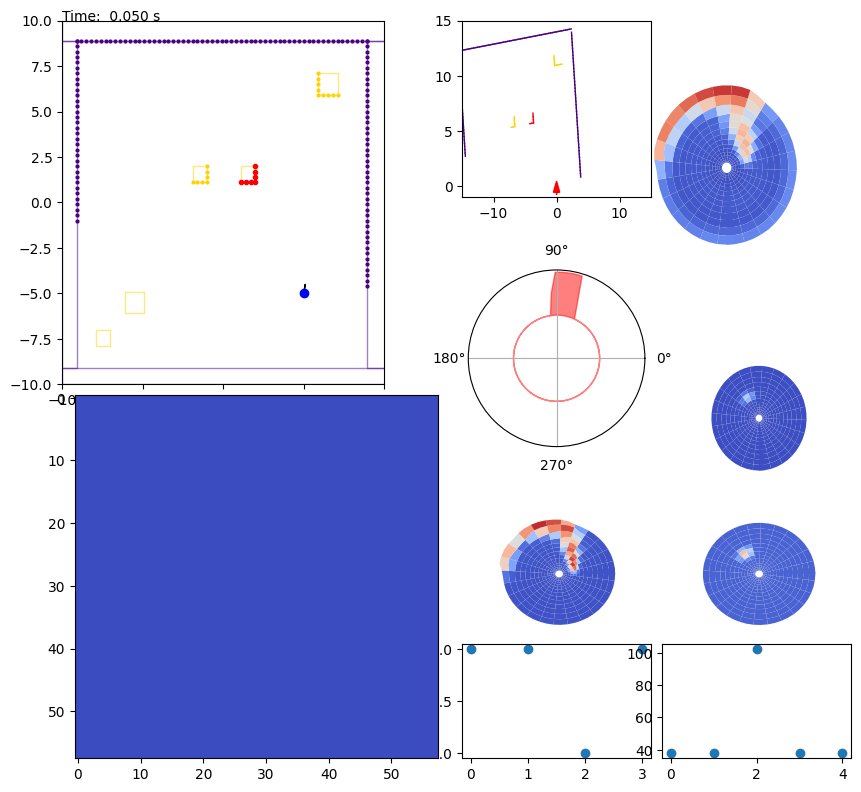

In [ ]:
%matplotlib inline
plt.show()

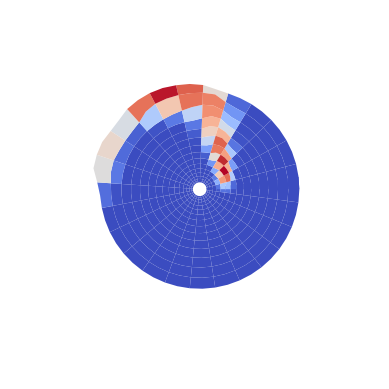

In [ ]:
%matplotlib inline
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

ax.plot_surface(
    x_bvc,
    y_bvc,
    np.reshape(cache['rates'].pw, (cache['tc_gen'].n_bvc_theta, cache['tc_gen'].n_bvc_r)),
    cmap='coolwarm'
)
ax.view_init(azim=-90, elev=90)
ax.set_axis_off()

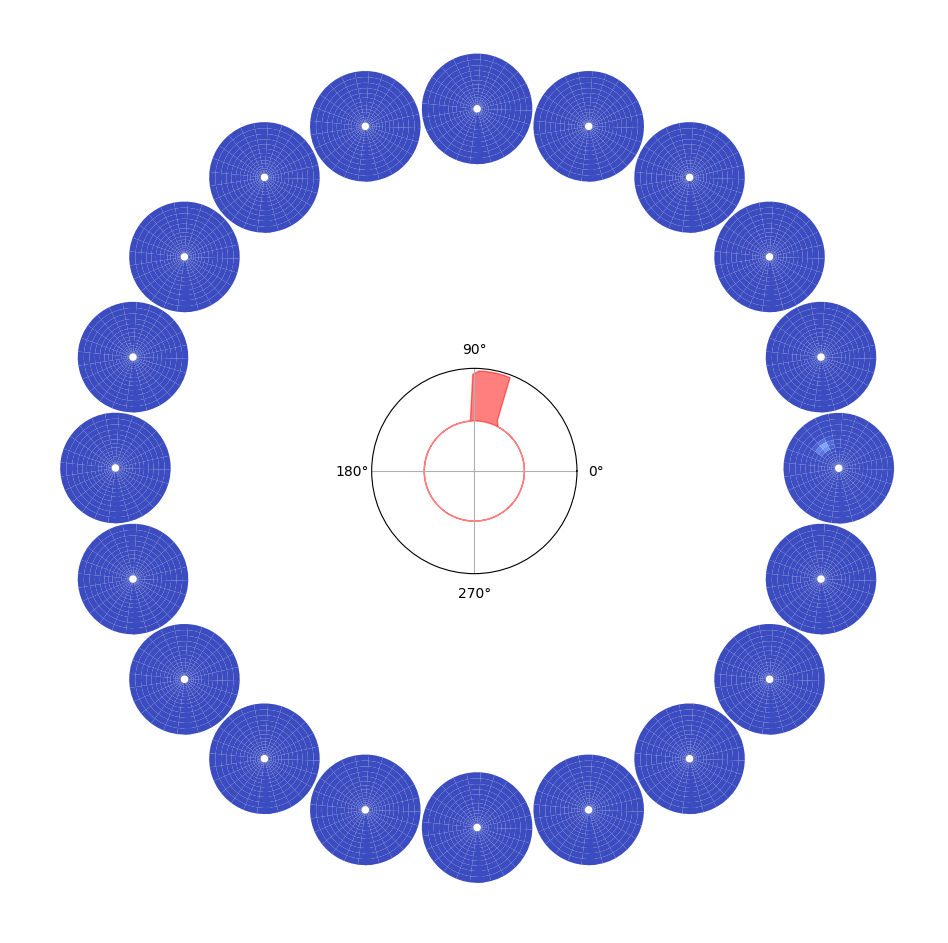

In [ ]:
fig, axs = create_circular_layout(20, 3.5, (20, 20))

for ax in axs:
    ax.set_facecolor((0.0, 0.0, 0.0, 0))


# axs[0].set_theta_zero_location('S')
axs[0].set_theta_direction(-1)
axs[0].set_xticks(np.linspace(0, 2*np.pi, 4, endpoint=False))
axs[0].set_xticklabels(['0°', '270°', '180°', '90°'])
axs[0].axes.get_yaxis().set_visible(False)

theta = np.linspace(0, 2*np.pi, len(cache['hd_cue']))
low = np.ones(len(cache['hd_cue']))/2
high = np.squeeze(cache['rates'].hd)
fill_condition = np.where(high >= low, high, low)
axs[0].fill(np.concatenate([theta, theta[::-1]]), np.concatenate([low, fill_condition]), color='red', alpha=0.5)

tc_axes = axs[1:]

for i in range(20):

    # ind = (i + 5) % 20
    ind = (i) % 20

    tc_axes[ind].plot_surface(
        x_bvc,
        y_bvc,
        np.reshape(cache['rates'].otr[i], (cache['tc_gen'].n_bvc_theta, cache['tc_gen'].n_bvc_r)),
        cmap='coolwarm',
        # vmax=cache['rates'].otr.max()
        vmin=0,
        vmax=1
    )
    tc_axes[ind].view_init(azim=0, elev=90)
    tc_axes[ind].set_axis_off()
    tc_axes[ind].set_zlim(0, cache['rates'].tr.max())

plt.show()

In [29]:
from typing import Mapping
from bbtoolkit.structures import BaseCallbacksManager, BaseCallback as _BaseCallback, CallbacksCollection


class ArtistCallback(_BaseCallback):
    def on_plot(self):
        ...
    def on_clean(self):
        ...

class PlottingCallback(BaseCallbacksManager, BaseCallback):
    def __init__(self, callbacks: list[ArtistCallback] = None, update_rate: int = 10, fig_kwargs: dict = None, gc_kwargs: dict = None):
        self.update_rate = update_rate
        fig_kwargs = fig_kwargs or dict()
        gc_kwargs = gc_kwargs or dict()
        self.fig_kwargs = fig_kwargs
        self.gc_kwargs = gc_kwargs
        self.callbacks = CallbacksCollection() if callbacks is None else CallbacksCollection(callbacks)
        BaseCallback.__init__(self)

    @property
    def cache(self):
        return self._cache

    @cache.setter
    def cache(self, cache: Mapping):
        self._cache = cache

    def set_cache(self, cache: Mapping):
        self.requires = ['fig', 'gc']
        cache['fig'] = plt.figure(**self.fig_kwargs)
        cache['gc'] = GridSpec(**self.gc_kwargs, figure=cache['fig'])
        super().set_cache(cache)
        self.callbacks.execute('set_cache', cache)
        try:
            self.callbacks.validate()
        except TypeError as e:
            raise TypeError(
                f'Error in {self.__class__.__name__}: Failed to validate callbacks due to: {e}\n'
                f'Note: {self.__class__.__name__} acts as both a BaseCallback and a BaseCallbacksManager.\n'
                f'This means that callbacks within {self.__class__.__name__} are nested within the scope of any external callbacks manager utilizing {self.__class__.__name__}.\n'
                'As a result, these nested callbacks have their own separate visibility scope.\n'
                f'If these nested callbacks depend on cache keys available in the external callbacks manager’s cache, they must be positioned before {self.__class__.__name__} in the execution order.'
            )


    def on_step_end(self, step: int):
        if not step % self.update_rate:
            self.plot()

    def on_simulation_end(self):
        plt.close()

    def plot(self):
        self.callbacks.execute('on_clean')
        self.callbacks.execute('on_plot')
        self.cache['fig'].canvas.draw()
        plt.pause(.00001)

In [30]:
from typing import Mapping


class AloEnvPlotter(ArtistCallback):
    def __init__(self):
        super().__init__()
        self.min_xy = None
        self.max_xy = None

    def set_cache(self, cache: Mapping):
        cache['alo_ax'] = cache['fig'].add_subplot(cache['gc'][:4, :4])
        self.requires = [
            'env',
            'walls_fov',
            'objects_fov',
            'alo_ax',
            'attention_params'
        ]
        super().set_cache(cache)
        coords_x, coords_y = self.env.visible_area.boundary.coords.xy
        min_train_x, max_train_x, min_train_y, max_train_y = min(coords_x), max(coords_x), min(coords_y), max(coords_y)
        self.min_xy = (min_train_x, min_train_y)
        self.max_xy = (max_train_x, max_train_y)

    def plot_environment(self):
        """
        Plots the environment, including walls and objects.
        """
        for obj in self.env.objects + self.env.walls:
            plot_polygon(obj.polygon, ax=self.alo_ax, alpha=0.5, linewidth=1)

    def plot_fov(self):
        """
        Plots the agent's field of view, showing visible walls and objects.
        """
        if self.walls_fov:
            for wall, poly in zip(self.walls_fov, self.env.walls):
                self.alo_ax.plot(wall[:, 0], wall[:, 1], 'o', color=poly.polygon.texture.color, markersize=2)
        if self.objects_fov:
            for i, (obj, poly) in enumerate(zip(self.objects_fov, self.env.objects)):
                if self.attention_params['attend_to'] is not None and i == self.attention_params['attend_to']:
                    self.alo_ax.plot(obj[:, 0], obj[:, 1], 'o', color='r', markersize=3)
                else:
                    self.alo_ax.plot(obj[:, 0], obj[:, 1], 'o', color=poly.polygon.texture.color, markersize=2)

    def on_plot(self):
        self.plot_environment()
        self.plot_fov()

    def on_clean(self):
        self.alo_ax.clear()
        self.alo_ax.set_xlim(self.min_xy[0], self.max_xy[0])
        self.alo_ax.set_ylim(self.min_xy[1], self.max_xy[1])


class TargetPlotter(ArtistCallback):
    def set_cache(self, cache: Mapping):
        self.requires = [
            'alo_ax',
            'movement_params'
        ]
        super().set_cache(cache)

    def on_plot(self):
        if self.movement_params.move_target is not None:
            self.alo_ax.plot(*self.movement_params.move_target, 'rx')
        if self.movement_params.rotate_target is not None:
            self.alo_ax.plot(*self.movement_params.rotate_target, 'co')


class AgentPlotter(ArtistCallback):
    def set_cache(self, cache: Mapping):
        self.requires = [
            'alo_ax',
            'movement_params'
        ]
        super().set_cache(cache)

    def on_plot(self):
        if self.movement_params.position is not None and self.movement_params.direction is not None:
            self.alo_ax.plot(*self.movement_params.position, 'bo')
            self.alo_ax.arrow(*self.movement_params.position, 0.5 * math.cos(self.movement_params.direction), 0.5 * math.sin(self.movement_params.direction))


class TrajectoryPlotter(ArtistCallback):
    def set_cache(self, cache: Mapping):
        self.requires = [
            'alo_ax',
            'movement_params',
            'movement_schedule',
            'trajectory'
        ]
        super().set_cache(cache)

    def on_plot(self):
        if self.movement_params.position is not None and \
            (not len(self.trajectory) or
            not (
                self.movement_params.move_target is not None
                and self.movement_params.move_target not in self.trajectory
            )):
            first_points = [self.movement_params.position, self.movement_params.move_target]\
                if self.movement_params.move_target not in self.movement_schedule\
                and self.movement_params.move_target is not None\
                else [self.movement_params.position]
            all_points = first_points + self.movement_schedule
            if len(self.movement_schedule):
                self.alo_ax.plot(
                    self.movement_schedule[-1][0],
                    self.movement_schedule[-1][1],
                    'ro'
                )
            for from_, to in zip(all_points[:-1], all_points[1:]):
                self.alo_ax.plot(*zip(from_, to), 'g-')


class EgoEnvPlotter(ArtistCallback):
    def __init__(self):
        super().__init__()
        self.min_xy = None
        self.max_xy = None

    def set_cache(self, cache: Mapping):
        cache['ego_ax'] = cache['fig'].add_subplot(cache['gc'][4:8, :4])
        self.requires = [
            'env',
            'walls_ego_segments',
            'objects_ego_segments',
            'ego_ax',
            'attention_params'
        ]
        super().set_cache(cache)
        coords_x, coords_y = self.env.visible_area.boundary.coords.xy
        min_train_x, max_train_x, min_train_y, max_train_y = min(coords_x), max(coords_x), min(coords_y), max(coords_y)
        # self.min_xy = (min_train_x, -1)
        # self.max_xy = (max_train_x, max_train_y - min_train_y)
        # d = sqrt(a^2 + b^2)
        d = np.sqrt((max_train_x - min_train_x)**2 + (max_train_y - min_train_y)**2)
        middle = (max_train_x + min_train_x)/2, (max_train_y + min_train_y)/2
        self.min_xy = (middle[0] - d, -1)
        self.max_xy = (middle[0] + d, d)


    def plot_ego(self):
        """
        Plots the ego-centric representation of walls and objects.
        """
        _ = plot_arrow(np.pi/2, 0, -.75, ax=self.ego_ax)

        if self.walls_ego_segments:
            for segments, poly in zip(self.walls_ego_segments, self.env.walls):
                for seg in segments:
                    x_start, y_start, x_end, y_end = seg
                    self.ego_ax.plot([x_start, x_end], [y_start, y_end], color=poly.polygon.texture.color, linewidth=1)

        if self.objects_ego_segments:
            for i, (segments, poly) in enumerate(zip(self.objects_ego_segments, self.env.objects)):
                color = 'r' if self.attention_params['attend_to'] is not None and i == self.attention_params['attend_to'] else poly.polygon.texture.color
                for seg in segments:
                    x_start, y_start, x_end, y_end = seg
                    self.ego_ax.plot([x_start, x_end], [y_start, y_end], color=color, linewidth=1)

    def on_plot(self):
        self.plot_ego()

    def on_clean(self):
        self.ego_ax.clear()
        self.ego_ax.set_xlim(self.min_xy[0], self.max_xy[0])
        self.ego_ax.set_ylim(self.min_xy[1], self.max_xy[1])


class MouseEventCallback(ArtistCallback):
    def set_cache(self, cache: Mapping):
        self.requires = ['fig', 'movement_params']
        super().set_cache(cache)
        self.fig.canvas.mpl_connect('button_press_event', self.on_click)

    def on_click(self, event: MouseEvent):
        """
        Handles mouse click events on the plot for setting movement and rotation targets.

        Args:
            event (MouseEvent): The mouse click event on the plot.
        """

        if event.inaxes is self.alo_ax:

            if event.button is MouseButton.LEFT:
                self.alo_ax.plot(event.xdata, event.ydata, 'rx')
                self.fig.canvas.draw()
                plt.pause(.00001)
                self.movement_params.move_target = event.xdata, event.ydata
                self.movement_paramsrotate_target = None
            elif event.button is MouseButton.RIGHT:
                self.alo_ax.plot(event.xdata, event.ydata, 'co')
                self.fig.canvas.draw()
                plt.pause(.00001)
                self.movement_params.rotate_target = event.xdata, event.ydata
                self.movement_params.move_target = None


class TimerCallback(BaseCallback):
    def set_cache(self, cache: Mapping):
        self.requires = ['dynamic_params']
        cache['dynamic_params']['step'] = 0
        super().set_cache(cache)

    def on_step_end(self, step: int):
        self.dynamic_params['step'] += 1


class TimerPlotter(ArtistCallback):

    def plot(self):
        self.alo_ax.text(-10, 10, f'Time: {(self.dynamic_params["step"])*self.dynamic_params["dt"] : .2f} s')

    def on_plot(self):
        self.plot()


class PWPlotter(ArtistCallback):
    def set_cache(self, cache: Mapping):
        cache['pw_ax'] = cache['fig'].add_subplot(cache['gc'][4:8, 4:8], projection='3d')
        self.requires = [
            'pw_ax',
            'rates',
            'env',
            'walls_pw',
            'tc_gen',
            'x_bvc',
            'y_bvc'
        ]
        polar_distance = calculate_polar_distance(cache['tc_gen'].r_max)
        polar_angle = np.linspace(
            0,
            (cache['tc_gen'].n_bvc_theta + 1) * cache['tc_gen'].polar_ang_res,
            cache['tc_gen'].n_bvc_theta
        )
        polar_distance, polar_angle = np.meshgrid(polar_distance, polar_angle)
        cache['x_bvc'], cache['y_bvc'] = pol2cart(polar_distance, polar_angle)
        super().set_cache(cache)

    def plot(self):
        """
        Plots the ego-centric representation of walls and objects.
        """
        self.pw_ax.plot_surface(
            self.x_bvc,
            self.y_bvc,
            np.reshape(self.rates.pw, (self.tc_gen.n_bvc_theta, self.tc_gen.n_bvc_r)),
            cmap='coolwarm',
            vmin=0, vmax=1
        )

    def on_plot(self):
        self.plot()

    def on_clean(self):
        self.pw_ax.clear()
        self.pw_ax.view_init(azim=-90, elev=90)
        self.pw_ax.margins(x=0, y=0)
        self.pw_ax.set_axis_off()

class BVCPlotter(ArtistCallback):
    def set_cache(self, cache: Mapping):
        cache['bvc_ax'] = cache['fig'].add_subplot(cache['gc'][:4, 4:8], projection='3d')
        self.requires = [
            'bvc_ax',
            'rates',
            'env',
            'walls_pw',
            'tc_gen',
            'x_bvc',
            'y_bvc'
        ]
        super().set_cache(cache)

    def plot(self):
        """
        Plots the ego-centric representation of walls and objects.
        """
        self.bvc_ax.plot_surface(
            self.x_bvc,
            self.y_bvc,
            np.reshape(self.rates.bvc, (self.tc_gen.n_bvc_theta, self.tc_gen.n_bvc_r)),
            cmap='coolwarm',
            vmin=0, vmax=1
        )

    def on_plot(self):
        self.plot()

    def on_clean(self):
        self.bvc_ax.clear()
        self.bvc_ax.view_init(azim=0, elev=90)
        self.bvc_ax.margins(x=0, y=0)
        self.bvc_ax.set_axis_off()

class oPWPlotter(ArtistCallback):
    def set_cache(self, cache: Mapping):
        cache['opw_ax'] = cache['fig'].add_subplot(cache['gc'][4:8, 8:], projection='3d')
        self.requires = [
            'opw_ax',
            'rates',
            'env',
            'walls_pw',
            'tc_gen',
            'x_bvc',
            'y_bvc'
        ]
        super().set_cache(cache)

    def plot(self):
        """
        Plots the ego-centric representation of walls and objects.
        """
        self.opw_ax.plot_surface(
            self.x_bvc,
            self.y_bvc,
            np.reshape(self.rates.opw, (self.tc_gen.n_bvc_theta, self.tc_gen.n_bvc_r)),
            cmap='coolwarm',
            vmin=0, vmax=1
        )

    def on_plot(self):
        self.plot()

    def on_clean(self):
        self.opw_ax.clear()
        self.opw_ax.view_init(azim=-90, elev=90)
        self.opw_ax.margins(x=0, y=0)
        self.opw_ax.set_axis_off()

class OVCPlotter(ArtistCallback):
    def set_cache(self, cache: Mapping):
        cache['ovc_ax'] = cache['fig'].add_subplot(cache['gc'][:4, 8:], projection='3d')
        self.requires = [
            'ovc_ax',
            'rates',
            'env',
            'walls_pw',
            'tc_gen',
            'x_bvc',
            'y_bvc'
        ]
        super().set_cache(cache)

    def plot(self):
        """
        Plots the ego-centric representation of walls and objects.
        """
        self.ovc_ax.plot_surface(
            self.x_bvc,
            self.y_bvc,
            np.reshape(self.rates.ovc, (self.tc_gen.n_bvc_theta, self.tc_gen.n_bvc_r)),
            cmap='coolwarm',
            vmin=0, vmax=1
        )

    def on_plot(self):
        self.plot()

    def on_clean(self):
        self.ovc_ax.clear()
        self.ovc_ax.view_init(azim=0, elev=90)
        self.ovc_ax.margins(x=0, y=0)
        self.ovc_ax.set_axis_off()


class HDPlotter(ArtistCallback):
    def __init__(self):
        super().__init__()
        self.theta = None
        self.low = None

    def set_cache(self, cache: Mapping):
        cache['hd_ax'] = cache['fig'].add_subplot(cache['gc'][8:, 8:], projection='polar')
        self.requires = [
            'hd_ax',
            'rates'
        ]
        super().set_cache(cache)
        theta = np.linspace(0, 2*np.pi, len(self.rates.hd))
        self.theta = np.concatenate([theta, theta[::-1]])
        self.low = np.ones(len(self.rates.hd))/2

    def plot(self):
        high = np.squeeze(self.rates.hd)
        fill_condition = np.where(high >= self.low, high, self.low)
        self.hd_ax.fill(self.theta, np.concatenate([self.low, fill_condition]), color='red', alpha=0.5)


    def on_plot(self):
        self.plot()

    def on_clean(self):
        self.hd_ax.clear()
        self.hd_ax.set_theta_zero_location('E')
        self.hd_ax.set_theta_direction(-1)
        self.hd_ax.set_xticks(np.linspace(0, 2*np.pi, 4, endpoint=False))
        self.hd_ax.set_xticklabels(['0°', '270°', '180°', '90°'])
        self.hd_ax.axes.get_yaxis().set_visible(False)


class GCPlotter(ArtistCallback):
    def __init__(self):
        self.side = None
        super().__init__()

    def set_cache(self, cache: Mapping):
        cache['gc_ax'] = cache['fig'].add_subplot(cache['gc'][8:, :4])
        self.requires = [
            'gc_ax',
            'rates'
        ]
        super().set_cache(cache)
        self.side = int(np.sqrt(len(self.rates.h)))

    def plot(self):
        self.gc_ax.imshow(
            np.reshape(self.rates.h, (self.side, self.side)).T,
            cmap='coolwarm',
            vmin=0, vmax=1
        )

    def on_plot(self):
        self.plot()

    def on_clean(self):
        self.gc_ax.clear()


In [31]:
import time


class DistanceAttention(RhythmicAttention):
    def __init__(self, freq: float, dt: float, n_objects: int, dist_threshold: float):
        super().__init__(freq, dt, n_objects)
        self.dist_threshold = dist_threshold

    @staticmethod
    def mean_dist_to_object(object_: np.ndarray, position: tuple[float, float] = (0, 0)) -> float:
        return np.mean(np.linalg.norm(object_ - position, axis=1))

    def visible_objects(self, objects: list[np.ndarray]) -> list[int]:
        """
        Determines which objects are visible (i.e., have a non-zero size).

        Args:
            objects (list[np.ndarray]): A list of objects represented as numpy arrays.

        Returns:
            list[int]: A list indicating the visibility of each object (True for visible, False for not visible).
        """
        return np.array([
            arr.size > 0
            and
            self.mean_dist_to_object(arr) < self.dist_threshold
            for arr in objects
        ])

class TimerPrinter(BaseCallback):

    def on_step_begin(self, step: int):
        self.time = time.time()

    def on_step_end(self, step):
        print(f'Time: {(self.dynamic_params["step"])*self.dynamic_params["dt"] : .2f} s, runtime: {time.time() - self.time} s')



In [32]:
%matplotlib qt


class DebugArtist(ArtistCallback):
    def set_cache(self, cache: Mapping):
        self.requires = ['fig', 'gc', 'rates', 'activity']
        cache['debug_ax1'] = cache['fig'].add_subplot(cache['gc'][8:10, 4:8])
        cache['debug_ax2'] = cache['fig'].add_subplot(cache['gc'][10:, 4:8])
        cache['fig'].tight_layout()
        super().set_cache(cache)

    def on_plot(self):
        self.debug_ax1.imshow(self.weights.opr.to.hd, aspect='auto', origin='lower')
        self.debug_ax2.plot(self.rates.opr, 'o')

    def on_clean(self):
        self.debug_ax1.clear()
        self.debug_ax2.clear()
        self.debug_ax2.set_ylim(0, 1)

dt = .005
# position = (-4, 7.5)
# position = (0, 0)
# position = (0, 0)
# position = (5, -5)
position = (7, -7)
# direction = np.pi/2
direction = 3*np.pi/4

cache = dict()
cache['dynamic_params'] = {'dt': dt}
cache['env'] = compiler.environment
cache['tc_gen'] = tc_gen
cache['k_ratio'] = k_ratio.copy()

cache['activity'] = activity.copy()
cache['rates'] = rates.copy()
cache['weights'] = weights.copy()
cache['weights'].tr.to.bvc = np.eye(len(weights.tr.to.bvc))
cache['weights'].bvc.to.tr = np.eye(len(weights.tr.to.bvc))
cache['connectivity'] = connectivity.copy()

dynamics = DynamicsManager(
    dt,
    callbacks=[
        TimerCallback(),
        MovementCallback(
            dt,
            MovementManager(
                5,
                math.pi*2,
                position,
                direction
                # np.pi/2
            )
        ),
        FOVCallback(fov_manager),
        EgoCallback(ego_manager),
        EgoSegmentationCallback(),
        ParietalWindowCallback(),
        MovementSchedulerCallback(),
        TrajectoryCallback(
            AStarTrajectory(
                compiler.environment,
                n_points=5,
                method='quadratic',
                dx=.5,
                poly_increase_factor=1.1
            )
        ),
        AttentionCallback(
            # RhythmicAttention(7, dt, len(compiler.environment.objects))
            DistanceAttention(7, dt, len(compiler.environment.objects), 7.5)
        ),
        HeadDirectionCallback(),
        GCRateCallback(gc_map),
        PCCallback(),
        BVCCallback(),
        OVCCallback(),
        PRCallback(),
        oPRCallback(),
        PWCallback(),
        oPWCallback(),
        IPRateCallback(),
        TCCallback(),
        oTCCallback(),
        ObjectWeightsUpdatingCallback(),
        TimerPrinter(),
        # PlottingCallback(
        #     [
        #         AloEnvPlotter(),
        #         EgoEnvPlotter(),
        #         MouseEventCallback(),
        #         TimerPlotter(),
        #         TargetPlotter(),
        #         AgentPlotter(),
        #         TrajectoryPlotter(),
        #         PWPlotter(),
        #         BVCPlotter(),
        #         oPWPlotter(),
        #         OVCPlotter(),
        #         HDPlotter(),
        #         GCPlotter(),
        #         DebugArtist()
        #     ],
        #     update_rate=5,
        #     fig_kwargs=dict(figsize=(10, 10)),
        #     gc_kwargs=dict(nrows=12, ncols=12)
        # )
    ],
    cache=cache
)


for _ in dynamics(True):
    print('out: ', _)

2024-04-14 15:04:44 - DEBUG - Loaded backend Qt5Agg version 5.15.9.


Time:  0.01 s, runtime: 7.891654968261719e-05 s
Time:  0.01 s, runtime: 8.344650268554688e-05 s
Time:  0.01 s, runtime: 7.724761962890625e-05 s
Time:  0.02 s, runtime: 8.678436279296875e-05 s
Time:  0.03 s, runtime: 8.058547973632812e-05 s
Time:  0.03 s, runtime: 9.72747802734375e-05 s
Time:  0.04 s, runtime: 9.560585021972656e-05 s
Time:  0.04 s, runtime: 8.0108642578125e-05 s
Time:  0.04 s, runtime: 0.00010824203491210938 s
Time:  0.05 s, runtime: 0.00011157989501953125 s
Time:  0.06 s, runtime: 7.462501525878906e-05 s
Time:  0.06 s, runtime: 6.961822509765625e-05 s
Time:  0.07 s, runtime: 9.775161743164062e-05 s
Time:  0.07 s, runtime: 7.2479248046875e-05 s
Time:  0.07 s, runtime: 8.7738037109375e-05 s
Time:  0.08 s, runtime: 9.965896606445312e-05 s
Time:  0.09 s, runtime: 0.000118255615234375 s


KeyboardInterrupt: 

## ASYNC STUFF

In [33]:
from bbtoolkit.data import asynchronous


class asyncHDCallback(BaseCallback):
    def __init__(self, init_timesteps: int = 30, hd_cue_scale: float = 60):
        super().__init__()
        self.init_timesteps = init_timesteps
        self.total_steps = 0
        self.hd_cue_scale = hd_cue_scale

    def set_cache(self, cache: Mapping):
        self.requires = [
            'dynamic_params',
            'tc_gen',
            'movement_params',
            'hd_cue',
            'k_ratio',
            'activity',
            'connectivity',
            'weights',
            'rates'
        ]

        cache['hd_cue'] = np.zeros(len(cache['weights'].hd.to.hd))
        super().set_cache(cache)
        self.dt = self.cache['dynamic_params']['dt']

    @asynchronous
    def get_k_ratio(self, rot_weights):
        return -self.activity.hd +\
            (self.connectivity.hd.to.hd['phi']*self.weights.hd.to.hd@self.rates.hd) +\
            self.hd_cue[:, np.newaxis] +\
            (self.connectivity.rot.to.rot['phi']*rot_weights@self.rates.hd)

    @asynchronous
    def get_activity(self):
        return self.activity.hd + self.dt/self.connectivity.hd.to.hd['tau']*self.k_ratio.hd

    @asynchronous
    def get_rate(self):
        return 1/(1 + np.exp(-2*self.connectivity.hd.to.hd['beta']*(self.activity.hd - self.connectivity.hd.to.hd['alpha'])))

    def on_step_begin(self, step: int):

        self.total_steps += 1
        if self.total_steps <= self.init_timesteps:
            # in order to make in-place operation
            self.hd_cue *= 0
            self.hd_cue += self.hd_cue_scale*self.tc_gen.get_hd_activity(np.array([self.movement_params.direction]))
        else:
            if not np.all(self.hd_cue == 0):
                logging.debug('HD CUE REMOVED')
                self.hd_cue *= 0

        rot_weights = None
        target = self.movement_params.move_target if self.movement_params.move_target is not None else self.movement_params.rotate_target
        if target is not None:
            angle_to_target = math.atan2(
                target[1] - self.movement_params.position[1],
                target[0] - self.movement_params.position[0]
            ) % (2*np.pi)

            if (angle_to_target - self.movement_params.direction) < 0:
                rot_weights = self.weights.rot.to.rot.T
            elif (angle_to_target - self.movement_params.direction) > 0:
                rot_weights = self.weights.rot.to.rot
            elif np.isclose(angle_to_target, self.movement_params.direction):
                rot_weights = None

        if rot_weights is None:
            rot_weights = np.zeros_like(self.weights.rot.to.rot)

        self.k_ratio.hd = self.get_k_ratio(rot_weights)
        self.activity.hd = self.get_activity()
        self.rates.hd = self.get_rate()

        # HD estimation
        popmax = np.where(self.rates.hd == np.max(self.rates.hd))[0][0]
        hd_estim = popmax*2*np.pi/(len(self.rates.hd) - 1) % (2*np.pi)

        self.movement_params.direction = hd_estim
        # logging.debug('HD')


class asyncPCCallback(BaseCallback):
    def __init__(self, i_comp: float = 0):
        super().__init__()
        # compensatory current to keep PC activty in check
        # was added to have similar amount of active PCs during
        # preplay as during normal sim.
        self.i_comp = i_comp

    def set_cache(self, cache: Mapping):
        cache['rates'].add_tensor(NamedTensor('i_comp', np.array([self.i_comp]).astype(float)))
        self.requires = [
            'dynamic_params',
            'k_ratio',
            'activity',
            'connectivity',
            'weights',
            'rates'
        ]
        super().set_cache(cache)
        self.dt = self.dynamic_params['dt']

    @asynchronous
    def get_k_ratio(self):
        return (
            - self.activity.h
            + self.connectivity.bvc.to.h['phi']*self.weights.bvc.to.h@self.rates.bvc
            + self.connectivity.h.to.h['phi']/3*self.weights.h.to.h@self.rates.h
            + self.connectivity.pr.to.h['phi']*self.weights.pr.to.h@self.rates.pr
            + self.connectivity.ovc.to.h['phi']*self.weights.ovc.to.h@self.rates.ovc
            + self.connectivity.gc.to.h['phi']*self.weights.gc.to.h@self.rates.gc
            + self.rates.i_comp
        )

    @asynchronous
    def get_activity(self):
        return self.activity.h + self.dt/self.connectivity.h.to.h['tau']*self.k_ratio.h

    @asynchronous
    def get_rate(self):
        return 1/(1 + np.exp(-2*self.connectivity.h.to.h['beta']*(self.activity.h - self.connectivity.h.to.h['alpha'])))

    @asynchronous
    def get_i_comp(self):
        return self.i_comp + self.dt/self.connectivity.ic.to.ic['tau']*(15 - np.sum(self.rates.h))

    def on_step_begin(self, step: int):
        self.cache['k_ratio'].h = self.get_k_ratio()


        self.activity.h = self.get_activity()
        self.rates.h = self.get_rate()
        # FIXME: What is the 15 in the equation?
        self.rates.i_comp = self.get_i_comp()
        # logging.debug('PC')


class asyncBVCCallback(BaseCallback):
    def set_cache(self, cache: Mapping):
        super().set_cache(cache)
        self.requires = [
            'dynamic_params',
            'k_ratio',
            'activity',
            'connectivity',
            'weights',
            'rates'
        ]
        self.dt = self.dynamic_params['dt']

    @asynchronous
    def get_k_ratio(self):
        return -self.activity.bvc +\
            self.connectivity.bvc.to.bvc['phi'] + self.weights.bvc.to.bvc @ self.rates.bvc +\
            self.connectivity.ovc.to.bvc['phi']*self.weights.ovc.to.bvc @ self.rates.ovc +\
            self.connectivity.pr.to.bvc['phi']*self.weights.pr.to.bvc @ self.rates.pr +\
            self.connectivity.tr.to.bvc['phi']*self.weights.tr.to.bvc @ np.sum(self.rates.tr, axis=0)

    @asynchronous
    def get_activity(self):
        return self.activity.bvc + self.dt/self.connectivity.bvc.to.bvc['tau']*self.k_ratio.bvc

    @asynchronous
    def get_rate(self):
        return 1/(1 + np.exp(-2*self.connectivity.bvc.to.bvc['beta']*(self.activity.bvc - self.connectivity.bvc.to.bvc['alpha'])))

    def on_step_begin(self, step: int):
        self.k_ratio.bvc = self.get_k_ratio()

        self.activity.bvc = self.get_activity()

        self.rates.bvc = self.get_rate()
        # logging.debug('BVC')


class asyncOVCCallback(BaseCallback):
    def set_cache(self, cache: Mapping):
        super().set_cache(cache)
        self.requires = [
            'dynamic_params',
            'k_ratio',
            'activity',
            'connectivity',
            'weights',
            'rates'
        ]
        self.dt = self.dynamic_params['dt']

    @asynchronous
    def get_k_ratio(self):
        return -self.activity.ovc +\
            self.connectivity.ovc.to.ovc['phi']*self.weights.ovc.to.ovc @ self.rates.ovc +\
            self.connectivity.bvc.to.ovc['phi']*self.weights.bvc.to.ovc @ self.rates.bvc +\
            self.connectivity.tr.to.ovc['phi']*self.weights.tr.to.bvc @ np.sum(self.rates.tr, axis=0)

    @asynchronous
    def get_activity(self):
        return self.activity.ovc + self.dt/self.connectivity.ovc.to.ovc['tau']*self.k_ratio.ovc

    @asynchronous
    def get_rate(self):
        return 1/(1 + np.exp(-2*self.connectivity.ovc.to.ovc['beta']*(self.activity.ovc - self.connectivity.ovc.to.ovc['alpha'])))

    def on_step_begin(self, step: int):
        self.k_ratio.ovc = self.get_k_ratio()
        self.activity.ovc = self.get_activity()
        self.rates.ovc = self.get_rate()
        # logging.debug('OVC')


class asyncPRCallback(BaseCallback):
    def __init__(self, pr_cue_scale: float = 50):
        super().__init__()
        self.pr_cue = None
        self.pr_cue_scale = pr_cue_scale

    def set_cache(self, cache: Mapping):
        super().set_cache(cache)
        self.requires = [
            'dynamic_params',
            'env',
            'walls_fov',
            'k_ratio',
            'activity',
            'connectivity',
            'weights',
            'rates'
        ]
        self.dt = self.dynamic_params['dt']

    @asynchronous
    def get_k_ratio(self, pr_cue):
        return -self.activity.pr +\
            self.connectivity.pr.to.pr['phi']*self.weights.pr.to.pr @ self.rates.pr +\
            self.connectivity.bvc.to.pr['phi']*self.weights.bvc.to.pr @ self.rates.bvc +\
            pr_cue

    @asynchronous
    def get_activity(self):
        return self.activity.pr + self.dt/self.connectivity.pr.to.pr['tau']*self.k_ratio.pr

    @asynchronous
    def get_rate(self):
        return 1/(1 + np.exp(-2*self.connectivity.pr.to.pr['beta']*(self.activity.pr - self.connectivity.pr.to.pr['alpha'])))

    def on_step_begin(self, step: int):

        pr_cue = get_pr_cue(self.env, self.walls_fov)[:, np.newaxis]

        self.pr_cue = self.pr_cue_scale*pr_cue/np.max(pr_cue)
        self.k_ratio.pr = self.get_k_ratio(self.pr_cue)
        self.activity.pr = self.get_activity()
        self.rates.pr = self.get_rate()
        # logging.debug('PR')


class asyncoPRCallback(BaseCallback):
    def __init__(self, opr_cue_scale: float = 200):
        super().__init__()
        self.opr_cue = None
        self.opr_cue_scale = opr_cue_scale

    def set_cache(self, cache: Mapping):
        super().set_cache(cache)
        self.requires = [
            'env',
            'dynamic_params',
            'k_ratio',
            'activity',
            'connectivity',
            'weights',
            'rates'
        ]
        self.opr_cue = np.zeros((len(self.env.objects), 1))
        self.dt = self.dynamic_params['dt']

    @asynchronous
    def get_k_ratio(self):
        return -self.activity.opr +\
            (
                self.connectivity.opr.to.opr['phi']*self.weights.opr.to.opr @ self.rates.opr +
                self.connectivity.h.to.opr['phi']*self.weights.h.to.opr @ self.rates.h +
                self.connectivity.ovc.to.opr['phi']*self.weights.ovc.to.opr @ self.rates.ovc
            ) + self.opr_cue_scale*self.opr_cue

    @asynchronous
    def get_activity(self):
        return self.activity.opr + self.dt/self.connectivity.opr.to.opr['tau']*self.k_ratio.opr

    @asynchronous
    def get_rate(self):
        return 1/(1 + np.exp(-2*self.connectivity.opr.to.opr['beta']*(self.activity.opr - self.connectivity.opr.to.opr['alpha'])))

    def on_step_begin(self, step: int):
        self.opr_cue *= 0
        if self.attention_params['attend_to'] is not None:
            self.opr_cue[self.attention_params['attend_to']] = 1 # currently one oPR neuron per object, however it can depend on texture

        self.k_ratio.opr = self.get_k_ratio()
        self.activity.opr = self.get_activity()
        self.rates.opr = self.get_rate()
        # logging.debug('oPR')


class asyncPWCallback(BaseCallback):
    def __init__(self, b_cue_scale: float = 48):
        super().__init__()
        self.b_cue_scale = b_cue_scale
    def set_cache(self, cache: Mapping):
        super().set_cache(cache)
        self.requires = [
            'dynamic_params',
            'k_ratio',
            'activity',
            'connectivity',
            'weights',
            'rates'
        ]
        self.dt = self.dynamic_params['dt']

    @asynchronous
    def get_k_ratio(self):
        return -self.activity.pw - 100*self.connectivity.pw.to.pw['inhibitory_phi'] +\
            np.sum(np.transpose(self.weights.tr.to.pw, (2, 0, 1)) @ self.rates.tr, axis=0) +\
            self.b_cue_scale*np.sum(self.cache['walls_pw'], axis=0)[:, np.newaxis]

    @asynchronous
    def get_activity(self):
        return self.activity.pw + self.dt/self.connectivity.pw.to.pw['tau']*self.k_ratio.pw

    @asynchronous
    def get_rate(self):
        return 1/(1 + np.exp(-2*self.connectivity.pw.to.pw['beta']*(self.activity.pw - self.connectivity.pw.to.pw['alpha'])))

    def on_step_begin(self, step: int):

        # FIXME: 100 is hardcoded
        self.k_ratio.pw = self.get_k_ratio()
        self.activity.pw = self.get_activity()
        self.rates.pw = self.get_rate()
        # logging.debug('PW')


class asyncoPWCallback(BaseCallback):
    def __init__(self, o_cue_scale: float = 30):
        super().__init__()
        self.attn_prev = None
        self.o_cue_scale = o_cue_scale

    def set_cache(self, cache: Mapping):
        super().set_cache(cache)
        self.requires = [
            'dynamic_params',
            'k_ratio',
            'activity',
            'connectivity',
            'weights',
            'rates'
        ]
        self.dt = self.dynamic_params['dt']

    @asynchronous
    def get_k_ratio(self):
        objects_pw_cue = self.o_cue_scale*self.objects_pw[self.attention_params['attend_to']][:, np.newaxis] if self.attention_params['attend_to'] is not None else 0

        return (
            -self.activity.opw
            - np.sum(self.rates.opw) * self.connectivity.opw.to.opw['inhibitory_phi']#*20
            + np.sum(np.transpose(self.weights.tr.to.pw, (2, 0, 1)) @ self.rates.otr, axis=0)
            + objects_pw_cue
        )

    @asynchronous
    def get_activity(self):
        return self.activity.opw + self.dt/self.connectivity.opw.to.opw['tau']*self.k_ratio.opw

    @asynchronous
    def get_rate(self):
        return 1/(1 + np.exp(-2*self.connectivity.opw.to.opw['beta']*(self.activity.opw - self.connectivity.opw.to.opw['alpha'])))

    def on_step_begin(self, step: int):
        self.k_ratio.opw = self.get_k_ratio()
        self.activity.opw = self.get_activity()
        self.rates.opw = self.get_rate()

        if self.attn_prev != self.attention_params['attend_to']:
            self.attn_prev = self.attention_params['attend_to']
            logging.debug(f'Switch attention to {self.attention_params["attend_to"]}')
        # logging.debug('oPW')


class asyncIPRateCallback(BaseCallback):
    def set_cache(self, cache: Mapping):
        super().set_cache(cache)
        self.requires = [
            'connectivity',
            'rates'
        ]

    @asynchronous
    def get_rate(self):
        return np.array([1/(1 + np.exp(-2*self.connectivity.ip.to.ip['beta']*(self.connectivity.hd.to.ip['phi']*np.sum(self.rates.hd) - self.connectivity.ip.to.ip['alpha'])))])

    def on_step_begin(self, step: int):
        # IPrate = 1./(1+exp(-2*IPbeta*(HD2IPphi*sum(HD_rate)-IPalpha)));

        self.rates.ip = self.get_rate()
        # logging.debug('IP')


class asyncTCCallback(BaseCallback):

    def set_cache(self, cache: Mapping):
        super().set_cache(cache)
        self.requires = [
            'dynamic_params',
            'k_ratio',
            'activity',
            'connectivity',
            'weights',
            'rates'
        ]
        self.dt = self.dynamic_params['dt']

    @asynchronous
    def get_k_ratio(self):
        return (
            -self.activity.tr
            - np.sum(self.rates.tr, axis=0) * self.connectivity.tr.to.tr['inhibitory_phi']
            + self.connectivity.hd.to.tr['phi']*np.transpose(self.weights.hd.to.tr, (2, 0, 1)) @ self.rates.hd
            - self.connectivity.ip.to.tr['phi']*self.rates.ip
            + self.connectivity.pw.to.tr['phi']*np.transpose(self.weights.pw.to.tr, (2, 0, 1)) @ self.rates.pw
        )

    @asynchronous
    def get_activity(self):
        return self.activity.tr + self.dt/self.connectivity.tr.to.tr['tau']*self.k_ratio.tr

    @asynchronous
    def get_rate(self):
        return 1/(1 + np.exp(-2*self.connectivity.tr.to.tr['beta']*(self.activity.tr - self.connectivity.tr.to.tr['alpha'])))

    def on_step_begin(self, step: int):
        self.k_ratio.tr = self.get_k_ratio()

        self.activity.tr = self.get_activity()

        self.rates.tr = self.get_rate()
        # logging.debug('TR')


class asyncoTCCallback(BaseCallback):

    def set_cache(self, cache: Mapping):
        super().set_cache(cache)
        self.requires = [
            'dynamic_params',
            'k_ratio',
            'activity',
            'connectivity',
            'weights',
            'rates'
        ]
        self.dt = self.dynamic_params['dt']

    @asynchronous
    def get_k_ratio(self):
        return (
            - self.activity.otr
            - np.sum(self.rates.otr, axis=0) * self.connectivity.otr.to.otr['inhibitory_phi']
            + self.connectivity.hd.to.tr['phi']*np.transpose(self.cache['weights'].hd.to.tr, (2, 0, 1)) @ self.rates.hd
            - self.connectivity.ip.to.otr['phi']*self.rates.ip
            + self.connectivity.opw.to.tr['phi']*np.transpose(self.cache['weights'].pw.to.tr, (2, 0, 1)) @ self.rates.opw
        )

    @asynchronous
    def get_activity(self):
        return self.activity.otr + self.dt/self.connectivity.otr.to.otr['tau']*self.k_ratio.otr

    @asynchronous
    def get_rate(self):
        return 1/(1 + np.exp(-2*self.connectivity.otr.to.otr['beta']*(self.activity.otr - self.connectivity.otr.to.otr['alpha'])))

    def on_step_begin(self, step: int):

        self.k_ratio.otr = self.get_k_ratio()
        self.activity.otr = self.get_activity()
        self.rates.otr = self.get_rate()
        # logging.debug('oTC')

In [34]:
from asyncio import Future
from bbtoolkit.data import asynchronous
import concurrent

class AsyncCache(dict):
    def __getitem__(self, key: Any) -> Any:
        future = super().__getitem__(key)
        if isinstance(future, concurrent.futures._base.Future):
            return future.result()
        else:
            return future

class AsyncTensorGroup(TensorGroup):
    def __init__(self, *tensors: NamedTensor):
        self._data = AsyncCache()
        for tensor in tensors:
            self.add_tensor(tensor)

    def __getattribute__(self, name: str) -> Any:
        future = super().__getattribute__(name)
        if isinstance(future, concurrent.futures._base.Future):
            return future.result()
        else:
            return future

In [39]:


dt = .005
position = (7, -7)
direction = 3*np.pi/4

cache = dict()
cache['dynamic_params'] = {'dt': dt}
cache['env'] = compiler.environment
cache['tc_gen'] = tc_gen

cache['k_ratio'] = AsyncTensorGroup(
    NamedTensor('h', np.zeros((n_h_neurons, 1))),
    NamedTensor('bvc', np.zeros((n_bvc_neurons, 1))),
    NamedTensor('pr', np.zeros((n_pr_neurons, 1))),
    NamedTensor('opr', np.zeros((n_objects, 1))),
    NamedTensor('hd', np.zeros((n_hd_neurons, 1))),
    NamedTensor('pw', np.expand_dims(40*ego_input_walls, 1)), # FIXME: why 40?
    NamedTensor('ovc', np.zeros((n_ovc_neurons, 1))),
    NamedTensor('opw', np.zeros((n_opw_neurons, 1))),
    NamedTensor('tr', np.zeros((n_tc_layers, n_bvc_neurons, 1))),
    NamedTensor('otr', np.zeros((n_tc_layers, n_bvc_neurons, 1))),
)
cache['activity'] = AsyncTensorGroup(
    NamedTensor('h', np.zeros((n_h_neurons, 1))),
    NamedTensor('bvc', np.zeros((n_bvc_neurons, 1))),
    NamedTensor('pr', np.zeros((n_pr_neurons, 1))),
    NamedTensor('pw', np.zeros((n_bvc_neurons, 1))),
    NamedTensor('hd', np.zeros((n_hd_neurons, 1))),
    NamedTensor('ovc', np.zeros((n_ovc_neurons, 1))),
    NamedTensor('opw', np.zeros((n_opw_neurons, 1))),
    NamedTensor('opr', np.zeros((n_objects, 1))),
    NamedTensor('tr', np.zeros((n_tc_layers, n_bvc_neurons, 1))),
    NamedTensor('otr', np.zeros((n_tc_layers, n_bvc_neurons, 1)))
)
cache['rates'] = AsyncTensorGroup(
    *[
        tensor for tensor in rates.copy()
    ]
)

cache['weights'] = weights.copy()
cache['weights'].tr.to.bvc = np.eye(len(weights.tr.to.bvc))
cache['weights'].bvc.to.tr = np.eye(len(weights.tr.to.bvc))
cache['connectivity'] = connectivity.copy()

dynamics = DynamicsManager(
    dt,
    callbacks=[
        TimerCallback(),
        MovementCallback(
            dt,
            MovementManager(
                5,
                math.pi*2,
                position,
                direction
                # np.pi/2
            )
        ),
        FOVCallback(fov_manager),
        EgoCallback(ego_manager),
        EgoSegmentationCallback(),
        ParietalWindowCallback(),
        MovementSchedulerCallback(),
        TrajectoryCallback(
            AStarTrajectory(
                compiler.environment,
                n_points=5,
                method='quadratic',
                dx=.5,
                poly_increase_factor=1.1
            )
        ),
        AttentionCallback(
            # RhythmicAttention(7, dt, len(compiler.environment.objects))
            DistanceAttention(7, dt, len(compiler.environment.objects), 7.5)
        ),
        asyncHDCallback(),
        GCRateCallback(gc_map),
        asyncPCCallback(),
        asyncBVCCallback(),
        asyncOVCCallback(),
        asyncPRCallback(),
        asyncoPRCallback(),
        asyncPWCallback(),
        asyncoPWCallback(),
        asyncIPRateCallback(),
        asyncTCCallback(),
        asyncoTCCallback(),
        ObjectWeightsUpdatingCallback(),
        TimerPrinter(),
        # PlottingCallback(
        #     [
        #         AloEnvPlotter(),
        #         EgoEnvPlotter(),
        #         MouseEventCallback(),
        #         TimerPlotter(),
        #         TargetPlotter(),
        #         AgentPlotter(),
        #         TrajectoryPlotter(),
        #         PWPlotter(),
        #         BVCPlotter(),
        #         oPWPlotter(),
        #         OVCPlotter(),
        #         HDPlotter(),
        #         GCPlotter(),
        #         DebugArtist()
        #     ],
        #     update_rate=10,
        #     fig_kwargs=dict(figsize=(10, 10)),
        #     gc_kwargs=dict(nrows=12, ncols=12)
        # )
    ],
    cache=cache
)


for _ in dynamics(1):
    print('out: ', _)

Time:  0.01 s, runtime: 0.00015878677368164062 s
Time:  0.01 s, runtime: 0.00014734268188476562 s
Time:  0.01 s, runtime: 0.0001590251922607422 s
Time:  0.02 s, runtime: 0.00013399124145507812 s
Time:  0.03 s, runtime: 0.0001499652862548828 s
Time:  0.03 s, runtime: 0.00014328956604003906 s
Time:  0.04 s, runtime: 0.000186920166015625 s
Time:  0.04 s, runtime: 0.00018262863159179688 s
Time:  0.04 s, runtime: 0.0001780986785888672 s
Time:  0.05 s, runtime: 0.0002002716064453125 s
Time:  0.06 s, runtime: 0.00013828277587890625 s
Time:  0.06 s, runtime: 0.00013184547424316406 s
Time:  0.07 s, runtime: 0.00016117095947265625 s
Time:  0.07 s, runtime: 0.00018024444580078125 s
Time:  0.07 s, runtime: 0.00020766258239746094 s
Time:  0.08 s, runtime: 0.00014400482177734375 s
Time:  0.09 s, runtime: 0.00019598007202148438 s
Time:  0.09 s, runtime: 0.0001347064971923828 s
Time:  0.10 s, runtime: 0.0001494884490966797 s
Time:  0.10 s, runtime: 0.000148773193359375 s
Time:  0.10 s, runtime: 0.0001

2024-04-14 15:06:59 - DEBUG - HD CUE REMOVED


Time:  0.15 s, runtime: 0.0001595020294189453 s
Time:  0.16 s, runtime: 0.00018286705017089844 s
Time:  0.17 s, runtime: 0.00016689300537109375 s
Time:  0.17 s, runtime: 0.00014662742614746094 s
Time:  0.18 s, runtime: 0.00014328956604003906 s
Time:  0.18 s, runtime: 0.00022840499877929688 s
Time:  0.18 s, runtime: 0.00015473365783691406 s
Time:  0.19 s, runtime: 0.00017881393432617188 s
Time:  0.20 s, runtime: 0.00016832351684570312 s
Time:  0.20 s, runtime: 0.00015926361083984375 s
Time:  0.21 s, runtime: 0.0001666545867919922 s
Time:  0.21 s, runtime: 0.00013637542724609375 s
Time:  0.21 s, runtime: 0.00018143653869628906 s
Time:  0.22 s, runtime: 0.00013971328735351562 s
Time:  0.23 s, runtime: 0.0002257823944091797 s
Time:  0.23 s, runtime: 0.00020742416381835938 s


KeyboardInterrupt: 

In [ ]:
cache['rates'].h

KeyboardInterrupt: 

In [ ]:
type(cache['rates'].hd)

concurrent.futures._base.Future